### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary


In [1]:
# to selectively re-import as needed
# import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']


In [2]:
from datetime import datetime
import os
import yaml
import sqlite3
import json
from collections import Counter
import uuid
from typing import TypedDict, Annotated

import operator
import pickle

import langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

from langchain_core.output_parsers import SimpleJsonOutputParser, JsonOutputParser, StrOutputParser

from langgraph.graph import StateGraph, START, END

import numpy as np
import pandas as pd
import umap

import sklearn
from sklearn.cluster import DBSCAN

import bs4
from urllib.parse import urljoin, urlparse

import multiprocessing
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

import openai
from openai import OpenAI

import trafilatura

VERBOSE=1
from ainb_const import (DOWNLOAD_DIR, PAGES_DIR,
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, CANONICAL_TOPICS,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT, TOP_CATEGORIES_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE, SQLITE_DB,
                        HOSTNAME_SKIPLIST, SITE_NAME_SKIPLIST,
                       )
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article,
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            unicode_to_ascii, send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file,
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory,
                            process_url_queue_factory, get_google_news_redirects)
from ainb_llm import (paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries,
                      fetch_openai_summary, count_tokens, trunc_tokens, 
                      categorize_headline, categorize_df, clean_topics,
                      get_site_name, fetch_missing_site_names)


import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()


In [3]:
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")


LangChain         0.3.0
OpenAI            1.47.0
trafilatura       1.12.2
numpy             1.26.4
pandas            2.2.3
sklearn           1.5.2
umap              0.5.6


In [4]:
# a basic LLM call with langchain
model = ChatOpenAI(model=MODEL)

model.invoke([
    SystemMessage(content="Translate the following from English into Italian"),
    HumanMessage(content='Listen to me. You are beautiful. You are perfect and I love you.'),
])


2024-10-02 18:01:06,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content='Ascoltami. Sei bellissima. Sei perfetta e ti amo.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 34, 'total_tokens': 50, 'completion_tokens_details': {'reasoning_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0}}, 'model_name': 'chatgpt-4o-latest', 'system_fingerprint': 'fp_bd428e1c3b', 'finish_reason': 'stop', 'logprobs': None}, id='run-0e8c64e5-f919-47f4-8e35-ccd9138dc7e6-0', usage_metadata={'input_tokens': 34, 'output_tokens': 16, 'total_tokens': 50})

In [5]:
# use template
system_template = "Translate the following into {language}:"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)
parser = StrOutputParser()
chain = prompt_template | model | parser
chain.invoke({"language": "italian", "text": "hi"})


2024-10-02 18:01:06,444 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Ciao'

In [6]:
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

system_template = 'Translate the following into {language}:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    response = ""
    # stream tokens as they are generated
    for r in chain.stream(tpl):
        print(r, end="")
        response += r
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")


2024-10-02 18:01:06,799 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.

2024-10-02 18:01:07,455 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.

2024-10-02 18:01:08,648 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Escúchame. Eres perfecto/a. Eres precioso/a y te amo.

2024-10-02 18:01:10,314 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ascoltami. Sei incredibile. Sei magnifica e ti amo.

2024-10-02 18:01:11,159 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Figyelj rám. Elbűvölő vagy. Lenyűgöző vagy, és szeretlek.

Elapsed seconds: 5.059688


In [7]:
# same but send all at once using asyncio

async def async_langchain(chain, input_dict):
    response = await chain.ainvoke(input_dict)
    return response


prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    task = asyncio.create_task(async_langchain(chain, d))
    tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()


difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")
print("\n".join(responses))


2024-10-02 18:01:12,162 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-02 18:01:12,578 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-02 18:01:12,582 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-02 18:01:13,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-02 18:01:13,241 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Elapsed seconds: 1.718811
Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.
Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.
Escúchame. Eres perfecta. Eres hermosa y te amo.
Ascoltami. Sei incredibile. Sei magnifico/a e ti amo.
Figyelj rám. Elbűvölő vagy. Lenyűgöző vagy, és szeretlek.


In [8]:
DEBUG = True
N_BROWSERS = 4
before_date = None
do_download = True
# before_date="2024-09-29 10:00:00"


In [9]:
# class to maintain settings and state within graph

class AgentState(TypedDict):
    AIdf: dict                #  the current working set of headlines (pandas dataframe not supported)
    before_date: str          #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool         #  if False use existing files, else download from sources
    sources: dict             #  sources to scrap
    sources_reverse: dict     #  map file names to sources
    headline_str: str         #  headline text email
    bullets: str              #  bullet point summary email
    summary: str              #  final summary
    n_edits: int              #  count edit iterations so we don't keep editing forever
    edit_complete: bool       #  edit will update if no more edits to make
    # message thread with OpenAI
    messages: Annotated[list[AnyMessage], operator.add]


In [10]:
# Initialize reading configurations from YAML file

def fn_initialize(state: AgentState) -> AgentState:
    """
    Initializes the agent state by loading source configurations from SOURCECONFIG (sources.yaml) .

    Args:
        state (AgentState): The current state of the agent.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        AgentState: The updated state of the agent.

    Raises:
        yaml.YAMLError: If there is an error while loading the YAML file.

    """

    #  load sources to scrape from sources.yaml
    with open(SOURCECONFIG, "r") as stream:
        try:
            state['sources'] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

    log(f"Initialized {len(state['sources'])} items in sources from {SOURCECONFIG}")

    # make a reverse dict to map file titles to source names
    state['sources_reverse'] = {}
    for k, v in state['sources'].items():
        log(f"{k} -> {v['url']} -> {v['title']}.html")
        v['sourcename'] = k
        # map filename (title) to source name
        state['sources_reverse'][v['title']] = k

    log(f"Initialized {len(state['sources_reverse'])} items in sources_reverse")

    return state


if DEBUG:
    test_state = AgentState()
    fn_initialize(test_state)


2024-10-02 18:01:13,272 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2024-10-02 18:01:13,273 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-10-02 18:01:13,273 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-10-02 18:01:13,273 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-10-02 18:01:13,274 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-10-02 18:01:13,274 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-10-02 18:01:13,274 - AInewsbot - INFO - 

In [11]:
# scrape sources with selenium and save local files in DOWNLOAD_DIR (htmldata)
def fn_download_sources(state: AgentState) -> AgentState:
    """
    Scrapes sources and saves HTML files.
    If state["do_download"] is True, deletes all files in DOWNLOAD_DIR (htmldata) and scrapes fresh copies.
    If state["do_download"] is False, uses existing files in DOWNLOAD_DIR.
    Uses state["sources"] for config info on sources to scrape
    For each source, saves the current filename to state["sources"][sourcename]['latest']

    Args:
        state (AgentState): The current state of the agent.
        do_delete (bool, optional): Whether to delete files in DOWNLOAD_DIR. Defaults to True.

    Returns:
        AgentState: The updated state of the agent.
    """

    if state["do_download"]:
        # empty download directory
        delete_files(DOWNLOAD_DIR)

        # save each file specified from sources
        log(f"Saving HTML files using {N_BROWSERS} browsers")

        # Create a queue for multiprocessing and populate it
        queue = multiprocessing.Queue()
        for item in state["sources"].values():
            queue.put(item)

        # Function to take the queue and pop entries off and process until none are left
        # lets you create an array of functions with different args
        callable = process_source_queue_factory(queue)

        saved_pages = launch_drivers(N_BROWSERS, callable)
        for sourcename, file in saved_pages:
            log(f"Downloaded {sourcename} to {file}")
            state['sources'][sourcename]['latest'] = file
        log(f"Saved {len(saved_pages)} HTML files")

    else:   # use existing files
        log(f"Web fetch disabled, using existing files in {DOWNLOAD_DIR}")
        # Get the current date
        datestr = datetime.now().strftime("%m_%d_%Y")
        files = [os.path.join(DOWNLOAD_DIR, file)
                 for file in os.listdir(DOWNLOAD_DIR)]
        # filter files with today's date ending in .html
        files = [
            file for file in files if datestr in file and file.endswith(".html")]
        log(f"Found {len(files)} previously downloaded files")
        for file in files:
            log(file)

        saved_pages = []
        for file in files:
            filename = os.path.basename(file)
            # locate date like '01_14_2024' in filename
            position = filename.find(" (" + datestr)
            basename = filename[:position]
            # match to source name
            sourcename = state["sources_reverse"].get(basename)
            if sourcename is None:
                log(f"Skipping {basename}, no sourcename metadata")
                continue
            state["sources"][sourcename]['latest'] = file

    return state

if DEBUG:
    test_state["do_download"] = do_download
    _ = fn_download_sources(test_state)


2024-10-02 18:01:13,287 - AInewsbot - INFO - Saving HTML files using 4 browsers
2024-10-02 18:01:13,299 - AInewsbot - INFO - get_driver - 25581 Initializing webdriver
2024-10-02 18:01:13,300 - AInewsbot - INFO - get_driver - 25581 Initializing webdriver
2024-10-02 18:01:13,301 - AInewsbot - INFO - get_driver - 25581 Initializing webdriver
2024-10-02 18:01:13,301 - AInewsbot - INFO - get_driver - 25581 Initializing webdriver
2024-10-02 18:01:29,644 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-02 18:01:29,644 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-02 18:01:29,644 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-02 18:01:29,644 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-02 18:01:29,645 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-02 18:01:29,645 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-02 18:01:29,645 - AInewsbot - INFO -

2024-10-02 18:02:51,336 - AInewsbot - INFO - get_files(Google News - Technology - Artificial intelligence) - Loading additional infinite scroll items
2024-10-02 18:03:01,367 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

2024-10-02 18:03:01,368 - AInewsbot - INFO - get_files(HackerNoon) - Saving HackerNoon (10_02_2024 06_03_01 PM).html as utf-8
2024-10-02 18:03:01,374 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit:

2024-10-02 18:03:36,331 - AInewsbot - INFO - get_files(Washington Post Technology) - Saving Washington Post Technology (10_02_2024 06_03_36 PM).html as utf-8
2024-10-02 18:03:36,333 - AInewsbot - INFO - Quit webdriver
2024-10-02 18:03:40,332 - AInewsbot - INFO - get_files(Feedly AI) - Loading additional infinite scroll items
2024-10-02 18:03:50,344 - AInewsbot - INFO - get_files(Feedly AI) - Loading additional infinite scroll items
2024-10-02 18:04:00,376 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

20

In [12]:
def fn_extract_urls(state: AgentState) -> AgentState:
    """
    Extracts news URLs from the latest HTML files matching the patterns defined in the state['sources'] configuration info.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted URLs stored in state['AIdf'].
    """
    # Parse news URLs and titles from downloaded HTML files
    log("Parsing html files")
    all_urls = []
    for sourcename, sourcedict in state['sources'].items():
        filename = sourcedict.get('latest')
        if not filename:
            log(f"no filename found for {sourcename}")
            continue

        log(sourcename + ' -> ' + filename)
        links = parse_file(state['sources'][sourcename])
        log(f"{len(links)} links found")
        all_urls.extend(links)

    log(f"Saved {len(all_urls)} links")

    # make a pandas dataframe of all the links found
    AIdf = (
        pd.DataFrame(all_urls)
        .groupby("url")
        .first()
        .reset_index()
        .sort_values("src")[["src", "title", "url"]]
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={"index": "id"})
    )
    state['AIdf'] = AIdf.to_dict()

    return state


if DEBUG:
    _ = fn_extract_urls(test_state)

    # s/b 17 but if some like bloomberg" or wsj are missing, maybe got a robot block
    # in that case download missing ones manually and then re-run extract
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])


2024-10-02 18:04:02,177 - AInewsbot - INFO - Parsing html files
2024-10-02 18:04:02,178 - AInewsbot - INFO - Ars Technica -> htmldata/Ars Technica (10_02_2024 06_02_39 PM).html
2024-10-02 18:04:02,251 - AInewsbot - INFO - parse_file - found 172 raw links
2024-10-02 18:04:02,256 - AInewsbot - INFO - parse_file - found 27 filtered links
2024-10-02 18:04:02,256 - AInewsbot - INFO - 27 links found
2024-10-02 18:04:02,256 - AInewsbot - INFO - Bloomberg Tech -> htmldata/Bloomberg Technology (10_02_2024 06_02_40 PM).html
2024-10-02 18:04:02,275 - AInewsbot - INFO - parse_file - found 198 raw links
2024-10-02 18:04:02,278 - AInewsbot - INFO - parse_file - found 16 filtered links
2024-10-02 18:04:02,278 - AInewsbot - INFO - 16 links found
2024-10-02 18:04:02,278 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider Tech (10_02_2024 06_02_39 PM).html
2024-10-02 18:04:02,301 - AInewsbot - INFO - parse_file - found 309 raw links
2024-10-02 18:04:02,305 - AInewsbot - INFO - parse_file 

17


,id
src,
Ars Technica,27
Bloomberg Tech,13
Business Insider,50
FT Tech,60
Feedly AI,55
Google News,66
Hacker News,28
Hacker News 2,19
HackerNoon,104


In [13]:
# sqlite schema to store previously processed 
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [14]:
# filter and clean URLs for new AI stories

def fn_filter_urls(state: AgentState) -> AgentState:
    """
    Filters the URLs in state["AIdf"] to include only those that have not been previously seen,
    and are related to AI according to the response from a ChatGPT prompt.

    Args:
        state (AgentState): The current state of the agent.
        before_date (str, optional): The date before which the URLs should be filtered. Defaults to "".

    Returns:


        AgentState: The updated state of the agent with the filtered URLs stored in state["AIdf"].

    """
    # filter to URL not previously seen
    AIdf = pd.DataFrame(state["AIdf"])

    AIdf = filter_unseen_urls_db(AIdf, before_date=state["before_date"])

    if len(AIdf) == 0:
        log("No new URLs, returning")
        return state

    # dedupe identical headlines
    # filter similar titles differing by type of quote or something
    AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)
    AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
    AIdf = AIdf.sort_values("src") \
        .groupby("title_clean") \
        .first() \
        .reset_index(drop=True) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})
    log(f"Found {len(AIdf)} unique new headlines")

    # structured response format
    json_schema = {
        "name": "json_schema",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "isai_array": {
                    "type": "array",
                    "items": {
                        "type": "object",
                                "properties": {
                                    "id": {
                                        "type": "number"
                                    },
                                    "isAI": {
                                        "type": "boolean"
                                    }
                                },
                        "required": ["id", "isAI"],
                        "additionalProperties": False
                    }
                }
            },
            "required": ["isai_array"],
            "additionalProperties": False
        }
    }

    # filter AI-related headlines using a prompt
    pages = paginate_df(AIdf)
    enriched_urls = asyncio.run(fetch_pages(pages, prompt=FILTER_PROMPT, json_schema=json_schema))
    filter_df = pd.DataFrame(enriched_urls)
    
    try:  # for idempotency
        AIdf = AIdf.drop(columns=['isAI'])
    except:
        pass

    # merge returned df with isAI column into original df on id column
    AIdf = pd.merge(AIdf, filter_df, on="id", how="outer")
    log(AIdf.columns)
    # set hostname based on actualurl
    AIdf['actual_url'] = AIdf['url']    # ideally resolve redirects but Google News blocks
    AIdf['hostname']=AIdf['actual_url'].apply(lambda url: urlparse(url).netloc)

    # update SQLite database with all seen URLs (we are doing this using url and ignoring redirects)
    log(f"Inserting {len(AIdf)} URLs into {SQLITE_DB}")
    conn = sqlite3.connect(SQLITE_DB)
    cursor = conn.cursor()
    for row in AIdf.itertuples():
        insert_article(conn, cursor, row.src, row.hostname, row.title,
                       row.url, row.actual_url, row.isAI, datetime.now().date())

    # keep headlines that are related to AI
    AIdf = AIdf.loc[AIdf["isAI"]==1] \
        .reset_index(drop=True)  \
        .reset_index()  \
        .drop(columns=["id"])  \
        .rename(columns={'index': 'id'})

    log(f"Found {len(AIdf)} AI headlines")

    # update actual URLs for Google News redirects
    # I think Google changed something so this no longer works, instead of a 301 redirct
    # get a javascript page that redirects. Also tomorrow we might see different URLs for same stories
    # AIdf = get_google_news_redirects(AIdf)

    conn = sqlite3.connect('articles.db')
    query = "select * from sites"
    sites_df = pd.read_sql_query(query, conn)
    sites_dict = {row.hostname:row.site_name for row in sites_df.itertuples()}
    conn.close()

    # get clean site_name
    AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))

    # if any missing clean site names, populate them using OpenAI
    missing_site_names =  len(AIdf.loc[AIdf['site_name']==""])
    if missing_site_names:
        log(f"Asking OpenAI for {missing_site_names} missing site names")
        responses = asyncio.run(fetch_missing_site_names(AIdf))
        # update site_dict from responses
        new_urls = []
        for r in responses:
            if r['url'].startswith('https://'):
                r['url'] = r['url'][8:]
            new_urls.append(r['url'])
            sites_dict[r['url']] = r['site_name']
            log(f"Looked up {r['url']} -> {r['site_name']}")
        # update sites table with new names
        for url in new_urls:
            sqlstr = "INSERT OR IGNORE INTO sites (hostname, site_name) VALUES (?, ?);"
            log(f"Updated {url} -> {sites_dict[url]}")
            conn.execute(sqlstr, (url, sites_dict[url]))
            conn.commit()
        # reapply to AIdf with updated sites
        AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))
    else:
        log("No missing site names")
  
    # drop banned slop sites

    AIdf = AIdf.loc[~AIdf["hostname"].str.lower().isin(HOSTNAME_SKIPLIST)]
    AIdf = AIdf.loc[~AIdf["site_name"].str.lower().isin(SITE_NAME_SKIPLIST)]
    
    state["AIdf"] = AIdf.to_dict()
    return state


if DEBUG:
    test_state["before_date"] = before_date
    _ = fn_filter_urls(test_state)
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    display(list(pd.DataFrame(test_state["AIdf"]).columns))



2024-10-02 18:16:00,932 - AInewsbot - INFO - Querying SQLite with where_clause: 
2024-10-02 18:16:01,537 - AInewsbot - INFO - URLs in orig_df: 913
2024-10-02 18:16:01,539 - AInewsbot - INFO - Existing URLs in DB: 154386
2024-10-02 18:16:01,565 - AInewsbot - INFO - New URLs in df filtered by URL: 277
2024-10-02 18:16:01,645 - AInewsbot - INFO - Existing src+title: 11
2024-10-02 18:16:01,645 - AInewsbot - INFO - New URLs in df filtered by src+title: 266
2024-10-02 18:16:01,655 - AInewsbot - INFO - Found 261 unique new headlines
2024-10-02 18:16:02,002 - AInewsbot - INFO - Applying prompt to 6 pages using gpt-4o-mini
2024-10-02 18:16:02,003 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:16:02,004 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:16:02,005 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:16:02,005 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:16:02,005 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:16:02,005 - AInewsbot - INFO - sent 11 items 
2024-10-02 18:16:0

,id
src,
Ars Technica,1
Bloomberg Tech,1
Business Insider,9
FT Tech,5
Feedly AI,44
Google News,22
Hacker News,3
Hacker News 2,2
HackerNoon,8


['id', 'src', 'title', 'url', 'isAI', 'actual_url', 'hostname', 'site_name']

In [15]:
# Function for topic extraction

def clean_topics(row, lcategories):
    """
    Cleans the extracted_topics and assigned_topics by removing certain common topics and combining them into a single list.

    Args:
        row (pandas.Series): The row containing the extracted_topics and assigned_topics.
        lcategories (set): The set of lowercase categories.

    Returns:
        list: The cleaned and combined list of topics.
    """
    extracted_topics = [x.title() for x in row.extracted_topics if x.lower() not in {"technology", "ai", "artificial intelligence"}]
    assigned_topics = [x.title() for x in row.assigned_topics if x.lower() in lcategories]
    combined = sorted(list(set(extracted_topics + assigned_topics)))
    combined = [s.replace("Ai", "AI") for s in combined]
    combined = [s.replace("Genai", "Gen AI") for s in combined]
    combined = [s.replace("Openai", "OpenAI") for s in combined]

    return combined


async def do_cat(AIdf, categories):
    """
    Sends a prompt to ChatGPT to select topics for the title for each row in AIdf
    which match the topics in categories.

    Args:
        AIdf (pandas.DataFrame): The DataFrame containing the headlines.
        categories (list): The list of topics to match with the headlines.

    Returns:
        dict: A dictionary where the keys are the row IDs and the values are lists
        of selected topics for each headline.

    """

    catdict = {}
    async with aiohttp.ClientSession() as session:
        for i, row in enumerate(AIdf.itertuples()):
            tasks = []
            log(f"Categorizing headline {row.id+1} of {len(AIdf)}")
            h = row.title
            log(h)
            for c in categories:
                task = asyncio.create_task(categorize_headline(h, c, session))
                tasks.append(task)
            responses = await asyncio.gather(*tasks)
            catdict[row.id] = [item for sublist in responses for item in sublist]
            log(str(catdict[row.id]))

    return catdict


def fn_topic_analysis(state: AgentState) -> AgentState:

    """
    Extracts and selects topics for each headline in the state['AIdf'] dataframe, scrubs them, and stores them back in the dataframe.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted and selected topics stored in state['AIdf'].
    """
    AIdf = pd.DataFrame(state["AIdf"])
    pages = paginate_df(AIdf)
    # apply topic extraction prompt to AI headlines
    log("start free-form topic extraction")
    json_schema = {
        "name": "extracted_topics",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "extracted_topics": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "id": {
                                "type": "number",
                            },
                            "topics": {
                                "type": "array",
                                "items": {
                                    "type": "string",
                                },
                            },
                        },
                        "required": ["id", "topics"],
                        "additionalProperties": False,
                    }
                }
            },
            "required": ["extracted_topics"],
            "additionalProperties": False,
        }
    }
    response = asyncio.run(fetch_pages(pages, prompt=TOPIC_PROMPT, json_schema=json_schema))
    topic_df = pd.DataFrame(response)
    topic_df = topic_df.rename(columns={'topics': 'extracted_topics'})
    log(f"{len(topic_df)} free-form topics extracted")
    all_topics = [item.lower() for row in topic_df.itertuples() for item in row.extracted_topics]
    item_counts = Counter(all_topics)
    filtered_topics = [item for item in item_counts if item_counts[item] >= 2 and item not in {'technology', 'ai', 'artificial intelligence'}]

    categories = sorted(CANONICAL_TOPICS)
    # use categories that are canonical or show up twice in freeform
    lcategories = set([c.lower() for c in categories] + [c.lower() for c in filtered_topics])
    # new topics
    log([c for c in filtered_topics if c not in categories])

    catdict = asyncio.run(categorize_headline(AIdf, categories=categories))
    topic_df['assigned_topics'] = topic_df['id'].apply(lambda id: catdict.get(id, ""))

    topic_df["topics"] = topic_df.apply(lambda t: clean_topics(t, lcategories), axis=1)
    topic_df["topic_str"] = topic_df.apply(lambda row: ", ".join(row.topics), axis=1)

    try: # for idempotency
        AIdf = AIdf.drop(columns=['topic_str', 'title_topic_str'])
    except:
        pass

    AIdf = pd.merge(AIdf, topic_df[["id", "topic_str"]], on="id", how="outer")
    AIdf['title_topic_str'] = AIdf.apply(lambda row: f'{row.title} (Topics: {row.topic_str})', axis=1)

    state["AIdf"] = AIdf.to_dict()
    return state

if DEBUG:
    _ = fn_topic_analysis(test_state)


2024-10-02 18:16:12,594 - AInewsbot - INFO - start free-form topic extraction
2024-10-02 18:16:12,594 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:16:12,595 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:16:12,595 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:16:12,595 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:16:15,270 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:16:25,511 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:16:29,047 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:16:29,050 - AInewsbot - INFO - Processed 107 responses.
2024-10-02 18:16:29,052 - AInewsbot - INFO - 107 free-form topics extracted
2024-10-02 18:16:29,054 - AInewsbot - INFO - ['economics', 'generative ai', 'coding', 'startup', 'poolside', 'funding', 'ebay', 'nvidia', 'podcast', 'content creation', 'accenture', 'partnership', 'training', 'enterprise', 'business group', 'employees', 'google', 'language models', 'chatbots', 'amazo

2024-10-02 18:17:54,592 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:17:54,594 - AInewsbot - INFO - Processed 107 responses.
2024-10-02 18:17:54,595 - AInewsbot - INFO - Autonomous vehicles, topic 12 of 154
2024-10-02 18:17:54,595 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:17:54,597 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:17:54,597 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:17:54,598 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:17:56,439 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:18:00,651 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:18:08,627 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:18:08,630 - AInewsbot - INFO - Processed 107 responses.
2024-10-02 18:18:08,631 - AInewsbot - INFO - Baidu, topic 13 of 154
2024-10-02 18:18:08,632 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:18:08,633 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:18

2024-10-02 18:19:39,568 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:19:39,569 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:19:39,570 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:19:39,571 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:19:41,170 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:19:44,780 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:19:46,832 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:19:46,834 - AInewsbot - INFO - Processed 107 responses.
2024-10-02 18:19:46,836 - AInewsbot - INFO - Code assistants, topic 26 of 154
2024-10-02 18:19:46,838 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:19:46,841 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:19:46,842 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:19:46,843 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:19:48,634 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:19:53,331 - AInewsbot - IN

2024-10-02 18:21:18,033 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:21:18,034 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:21:19,715 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:21:24,969 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:21:25,000 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:21:25,002 - AInewsbot - INFO - Processed 107 responses.
2024-10-02 18:21:25,003 - AInewsbot - INFO - Demis Hassabis, topic 39 of 154
2024-10-02 18:21:25,004 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:21:25,005 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:21:25,007 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:21:25,008 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:21:26,471 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:21:31,796 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:21:33,230 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:21:33,233 - AInewsbot - INFO - Processe

2024-10-02 18:23:03,055 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:23:05,905 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:23:05,908 - AInewsbot - INFO - Processed 107 responses.
2024-10-02 18:23:05,908 - AInewsbot - INFO - Finance, topic 52 of 154
2024-10-02 18:23:05,910 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:23:05,910 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:23:05,912 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:23:05,913 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:23:09,478 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:23:11,128 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:23:11,131 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:23:11,138 - AInewsbot - INFO - Processed 107 responses.
2024-10-02 18:23:11,139 - AInewsbot - INFO - Fintech, topic 53 of 154
2024-10-02 18:23:11,140 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:23:

2024-10-02 18:25:02,539 - AInewsbot - INFO - History, topic 65 of 154
2024-10-02 18:25:02,540 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:25:02,541 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:25:02,541 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:25:02,542 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:25:03,874 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:25:08,259 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:25:09,199 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:25:09,202 - AInewsbot - INFO - Processed 107 responses.
2024-10-02 18:25:09,203 - AInewsbot - INFO - Hollywood, topic 66 of 154
2024-10-02 18:25:09,204 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:25:09,204 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:25:09,205 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:25:09,206 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:25:10,286 - AInewsbot - INFO -

2024-10-02 18:26:31,156 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:26:31,158 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:26:31,160 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:26:32,456 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:26:37,575 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:26:41,577 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:26:41,580 - AInewsbot - INFO - Processed 107 responses.
2024-10-02 18:26:41,581 - AInewsbot - INFO - Jobs & CareersLabor Market, topic 79 of 154
2024-10-02 18:26:41,583 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:26:41,584 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:26:41,587 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:26:41,588 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:26:42,679 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:26:47,788 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:26:48,633 - AInewsbot - INFO - got d

2024-10-02 18:28:15,684 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:28:16,799 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:28:21,412 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:28:21,413 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:28:21,415 - AInewsbot - INFO - Processed 107 responses.
2024-10-02 18:28:21,415 - AInewsbot - INFO - Music, topic 92 of 154
2024-10-02 18:28:21,416 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:28:21,418 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:28:21,419 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:28:21,420 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:28:22,845 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:28:27,152 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:28:28,679 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:28:28,680 - AInewsbot - INFO - Processed 107 responses.
2024-10-02 18:28:28,681 - AInewsbot - INFO - Mustafa

2024-10-02 18:30:06,395 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:30:06,397 - AInewsbot - INFO - Processed 107 responses.
2024-10-02 18:30:06,398 - AInewsbot - INFO - Privacy, topic 105 of 154
2024-10-02 18:30:06,399 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:30:06,400 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:30:06,401 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:30:06,402 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:30:07,817 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:30:12,877 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:30:12,940 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:30:12,943 - AInewsbot - INFO - Processed 107 responses.
2024-10-02 18:30:12,944 - AInewsbot - INFO - Privacy & Surveillance, topic 106 of 154
2024-10-02 18:30:12,945 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:30:12,947 - AInewsbot - INFO - sent 50 items 
2024-10-0

2024-10-02 18:31:53,493 - AInewsbot - INFO - SAP, topic 118 of 154
2024-10-02 18:31:53,494 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:31:53,496 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:31:53,497 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:31:53,498 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:31:55,201 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:32:01,843 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:32:02,399 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:32:02,401 - AInewsbot - INFO - Processed 107 responses.
2024-10-02 18:32:02,401 - AInewsbot - INFO - Safety and Alignment, topic 119 of 154
2024-10-02 18:32:02,402 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:32:02,403 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:32:02,405 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:32:02,406 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:32:03,647 - AInewsbot

2024-10-02 18:33:40,813 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:33:40,814 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:33:40,816 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:33:41,959 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:33:45,765 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:33:48,697 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:33:48,701 - AInewsbot - INFO - Processed 107 responses.
2024-10-02 18:33:48,702 - AInewsbot - INFO - Sports, topic 132 of 154
2024-10-02 18:33:48,703 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:33:48,705 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:33:48,706 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:33:48,707 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:33:50,231 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:34:00,267 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:34:00,412 - AInewsbot - INFO - got dict with 50 items 


2024-10-02 18:35:36,628 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:35:43,592 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:35:43,594 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:35:43,596 - AInewsbot - INFO - Processed 107 responses.
2024-10-02 18:35:43,596 - AInewsbot - INFO - Transportation, topic 145 of 154
2024-10-02 18:35:43,597 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-02 18:35:43,598 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:35:43,599 - AInewsbot - INFO - sent 50 items 
2024-10-02 18:35:43,599 - AInewsbot - INFO - sent 7 items 
2024-10-02 18:35:45,538 - AInewsbot - INFO - got dict with 7 items 
2024-10-02 18:35:50,760 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:35:53,524 - AInewsbot - INFO - got dict with 50 items 
2024-10-02 18:35:53,527 - AInewsbot - INFO - Processed 107 responses.
2024-10-02 18:35:53,527 - AInewsbot - INFO - Travel, topic 146 of 154
2024-10-02 18:35:53,528 - AInew

In [16]:
async def write_topic_name(session, topic_list_str, max_retries=3, model=LOWCOST_MODEL):
    """
    Generates a name for a cluster based on a list of headline topics.

    Parameters:
    session (aiohttp.ClientSession): The client session for making async HTTP requests.
    topic_list_str (str): A string containing the list of headline topics.
    max_retries (int, optional): The maximum number of retries in case of an error. Defaults to 3.
    model (str, optional): The model to use for generating the topic name. Defaults to LOWCOST_MODEL.

    Returns:
    dict: A dictionary containing the generated topic name.

    Example Usage:
    title_topic_str_list = "Headline 1 (Topic: Topic 1)\n\nHeadline 2 (Topic: Topic 2)"
    result = await write_topic_name(session, title_topic_str_list)
    print(result)

    Output:
    {"topic_title": "Generated Topic Name"}
    ```
    """
    TOPIC_WRITER_PROMPT = f"""
You are a topic writing assistant. I will provide a list of headlines with extracted topics in parentheses.
Your task is to propose a name for a topic that very simply, clearly and accurately captures all the provided
headlines in less than 7 words. You will output a JSON object with the key "topic_title".

Example Input:
In the latest issue of Caixins weekly magazine: CATL Bets on 'Skateboard Chassis' and Battery Swaps to Dispell Market Concerns (powered by AI) (Topics: Battery Swaps, Catl, China, Market Concerns, Skateboard Chassis)

AI, cheap EVs, future Chevy  the week (Topics: Chevy, Evs)

Electric Vehicles and AI: Driving the Consumer & World Forward (Topics: Consumer, Electric Vehicles, Technology)

Example Output:
{{"topic_title": "Electric Vehicles"}}

Task
Propose the name for the overall topic based on the following provided headlines and individual topics:

{topic_list_str}
"""

    for i in range(max_retries):
        try:
            messages=[
                      {"role": "user", "content": TOPIC_WRITER_PROMPT
                      }]

            payload = {"model":  model,
                       "response_format": {"type": "json_object"},
                       "messages": messages,
                       "temperature": 0
                       }
#             print(topic_list_str)
            response = asyncio.run(fetch_openai(session, payload))
            response_dict = json.loads(response["choices"][0]["message"]["content"])
            return response_dict

            break
        except Exception as exc:
            log(f"Error: {exc}")

    return {}


async def afn_topic_clusters(state: AgentState) -> AgentState:
    """
    Fetches embeddings for the headlines, creates clusters of similar articles using DBSCAN, and sorts
    using the clusters and a traveling salesman shortest traversal in embedding space.

    Parameters:
    state (AgentState): The state of the agent.

    Returns:
    AgentState: The updated state of the agent.

    """
    AIdf = pd.DataFrame(state["AIdf"])

    log(f"Fetching embeddings for {len(AIdf)} headlines")
    embedding_model = 'text-embedding-3-large'
    client = OpenAI()
    response = client.embeddings.create(input=AIdf['title_topic_str'].tolist(),
                                        model=embedding_model)
    embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])

    # greedy traveling salesman sort
    log(f"Sort with nearest_neighbor_sort sort")
    sorted_indices = nearest_neighbor_sort(embedding_df)
    AIdf['sort_order'] = sorted_indices

    # do dimensionality reduction on embedding_df and cluster analysis
    log(f"Perform dimensionality reduction")
    with open("reducer.pkl", 'rb') as file:
        # Load the model from the file
        reducer = pickle.load(file)
    reduced_data = reducer.transform(embedding_df)
    log(f"Cluster with DBSCAN")
    dbscan = DBSCAN(eps=0.4, min_samples=3)  # Adjust eps and min_samples as needed
    AIdf['cluster'] = dbscan.fit_predict(reduced_data)
    AIdf.loc[AIdf['cluster'] == -1, 'cluster'] = 999

    # sort first by clusters found by DBSCAN, then by semantic ordering
    AIdf = AIdf.sort_values(['cluster', 'sort_order']) \
        .reset_index(drop=True) \
        .reset_index() \
        .drop(columns=["id"]) \
        .rename(columns={'index': 'id'})

    # show clusters
    cluster_topics = []
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        async with aiohttp.ClientSession() as session:
            for i in range(30):
                tmpdf = AIdf.loc[AIdf['cluster']==i][["id", "title_topic_str"]]
                if len(tmpdf) ==0:
                    break
                display(tmpdf)
                title_topic_str_list = ("\n\n".join(tmpdf['title_topic_str'].to_list()))
                cluster_topic = await write_topic_name(session, title_topic_str_list)
                cluster_topic = cluster_topic['topic_title']
                cluster_topics.append(cluster_topic)
                log(f"I dub this cluster: {cluster_topic}")
    state["cluster_topics"] = cluster_topics
    AIdf["cluster_name"] = AIdf['cluster'].apply(lambda i: cluster_topics[i] if i < len(cluster_topics) else "")
    state["AIdf"] = AIdf.to_dict()
    return state

# TODO: could add a quality rating for stories based on site reputation, length, complexity of story
# could then add the quality rating to the summaries and tell the prompt to favor high-quality stories
# could put summaries into vector store and retrieve stories by topic. but then you will have to deal
# with duplicates across categories, ask the prompt to dedupe

def fn_topic_clusters(state: AgentState) -> AgentState:
    "call async afn_topic_clusters on state"
    asyncio.run(afn_topic_clusters(state))
    return state


if DEBUG:
    _ = fn_topic_clusters(test_state)


2024-10-02 18:37:02,488 - AInewsbot - INFO - Fetching embeddings for 107 headlines
2024-10-02 18:37:02,997 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-10-02 18:37:03,375 - AInewsbot - INFO - Sort with nearest_neighbor_sort sort
2024-10-02 18:37:03,400 - AInewsbot - INFO - Perform dimensionality reduction
2024-10-02 18:37:06,416 - AInewsbot - INFO - Cluster with DBSCAN


,id,title_topic_str
0,0,"For Nvidia, spatial AI and the omniverse entering physical world may be the next big thing (Topics: Big Tech, Computer Vision, Economics, Hardware, Jensen Huang, Nvidia, Omniverse, Science, Semiconductor Chips, Spatial AI, Virtual & Augmented Reality)"
1,1,"Nvidia Partners With Accenture to Boost Corporate AI Adoption (Topics: Accenture, Big Tech, Corporate AI, Gen AI, Jensen Huang, Nvidia, Partnership, Science, Semiconductor Chips)"
2,2,"Nvidia Teams Up With Accenture to Boost Corporate AI Use (Topics: Accenture, Big Tech, Collaboration, Corporate AI, Gen AI, Jensen Huang, Nvidia, Science, Semiconductor Chips)"
3,3,"Accenture forms new Nvidia business group focused on agentic AI adoption (Topics: Accenture, Adoption, Big Tech, Business Group, Deals, Economics, Hardware, Jensen Huang, Nvidia, Safety And Alignment, Science, Semiconductor Chips, Stocks)"
4,4,"Accenture and NVIDIA Partner to Train 30,000 Professionals to Scale Agentic AI for Enterprises (Topics: Accenture, Big Tech, Deals, Economics, Education, Enterprise, Hardware, Jensen Huang, Jobs & Careerslabor Market, Nvidia, Professionals, Safety And Alignment, Science, Semiconductor Chips, Stocks, Training)"
5,5,"Accenture says it will train 30,000 employees on Nvidia technology and start a new Nvidia Business Group focused on driving enterprise adoption of AI agents (Topics: Accenture, Big Tech, Business Group, Deals, Economics, Education, Employees, Hardware, Jensen Huang, Jobs & Careerslabor Market, Nvidia, Safety And Alignment, Science, Semiconductor Chips, Stocks, Training, Virtual Assistants)"


2024-10-02 18:37:07,154 - AInewsbot - INFO - I dub this cluster: Nvidia and Accenture in AI Innovation


,id,title_topic_str
6,6,"Character.AI CEO Dominic Perella says the startup has largely abandoned building AI models after Google poached its founders, focusing on its chatbots instead (Topics: AI Models, Big Tech, Character.AI, Chatbots, Chatgpt, Deals, Dominic Perella, Google, Language Models, Mergers And Acquisitions, Science, Sergey Brin, Virtual Assistants)"
7,7,"Character.ai abandons making AI models after $2.7bn Google deal (Topics: AI Models, Big Tech, Character.AI, Chatbots, Chatgpt, Deal, Deals, Finance, Funding, Google, Language Models, Larry Page, Mergers And Acquisitions, Science, Sergey Brin, Virtual Assistants)"
8,8,"After Google's $2.7B Acquisition Of Founders And Staff, This AI Startup Abandons Large Language Model Plans And Shifts Focus Away From Chatbots (Topics: Acquisition, Big Tech, Chatbots, Chatgpt, Deals, Google, Language Models, Mergers And Acquisitions, Science, Sergey Brin, Startup)"


2024-10-02 18:37:07,869 - AInewsbot - INFO - I dub this cluster: Character.AI and Google's Impact on AI


,id,title_topic_str
9,9,"Apparate: Early-Exit Models for ML Latency and Throughput Optimization - Overall Results (Topics: Latency, Ml, Optimization, Results, Science, Testing, Throughput)"
10,10,"Apparate: Early-Exit Models for ML Latency and Throughput Optimization - Preparing Models (Topics: Latency, Ml, Optimization, Preparation, Science, Testing, Throughput)"
11,11,"Researchers from KAIST and Google AI Introduce Blockwise Parallel Decoding (BCD): An AI Method for Rescoring Algorithms for Improved Efficiency and Fluency in Language Models (Topics: Big Tech, Blockwise Parallel Decoding, Cognitive Science, Education, Gen AI, Google, Google AI, Kaist, Korea, Language Models, Science, Speech Recognition & Synthesis)"
12,12,"Apparate: Early-Exit Models for ML Latency and Throughput Optimization - Implementation (Topics: Implementation, Latency, Ml, Optimization, Science, Testing, Throughput)"
13,13,"Apparate: Early-Exit Models for ML Latency and Throughput Optimization - Accurate Threshold Tuning (Topics: Latency, Ml, Models, Optimization, Science, Testing, Throughput)"
14,14,"Apparate: Early-Exit Models for ML Latency and Throughput Optimization - Latency-Focused Adjustments (Topics: Adjustments, Latency, Ml, Optimization, Science, Testing, Throughput)"
15,15,"Apparate: Early-Exit Models for ML Latency and Throughput Optimization - Evaluation and Methodology (Topics: Evaluation, Latency, Methodology, Ml, Optimization, Science, Testing, Throughput)"
16,16,"Apparate: Early-Exit Models for ML Latency and Throughput Optimization - Comparisons (Topics: Comparisons, Latency, Ml, Optimization, Science, Testing, Throughput)"


2024-10-02 18:37:08,689 - AInewsbot - INFO - I dub this cluster: Machine Learning Latency Optimization


,id,title_topic_str
17,17,"California spiked a landmark AI regulation. But that doesnt mean the bill is going away (Topics: AI Doom, Bias And Fairness, California, Ethics, Governance, Inequality, Legal Issues, Legislation, Opinion, Policy And Regulation, Politics, Regulation, Safety And Alignment, Science)"
18,18,"Californias AI bill was well-meaning but flawed (Topics: AI Doom, Bias And Fairness, California, Ethics, Governance, Inequality, Legal Issues, Legislation, Opinion, Policy And Regulation, Politics, Regulation, Safety And Alignment, Science)"
19,19,"What Gavin Newsom just did to the global AI debate (Topics: Gavin Newsom, Gen AI, Global Debate, Governance, Policy, Policy And Regulation, Politics)"


2024-10-02 18:37:09,611 - AInewsbot - INFO - I dub this cluster: AI Regulation and Governance in California


,id,title_topic_str
20,20,"OpenAI just raised $6.6 billion to build ever-larger AI models (Topics: AI Models, Big Tech, Chatgpt, Claude, Economics, Finance, Funding, Gen AI, Ilya Sutskever, Investment, Ipos, Language Models, OpenAI, Perplexity, Sam Altman, Science, Stocks, Venture Capital)"
21,21,"Cathie Wood's Ark is doubling down on OpenAI with at least $250 million in its new funding round (Topics: Ark, Big Tech, Cathie Wood, Chatgpt, Claude, Deals, Economics, Finance, Funding, Ilya Sutskever, Investment, Language Models, Open Source, OpenAI, Sam Altman, Science, Stocks, Venture Capital)"
22,22,"Tiger Global is backing OpenAI in new $6.6 billion investment round (Topics: $6.6 Billion, Big Tech, Bill Gates, Chatgpt, Claude, Deals, Economics, Finance, Funding, Gen AI, Ilya Sutskever, Investment, Ipos, Language Models, Mergers And Acquisitions, Microsoft, OpenAI, Perplexity, Sam Altman, Satya Nadella, Stocks, Tiger Global, Venture Capital)"
23,23,"The investors behind OpenAI's historic $6.6 billion funding round (Topics: $6.6 Billion, Big Tech, Bill Gates, Chatgpt, Claude, Deals, Economics, Finance, Funding, Gen AI, Ilya Sutskever, Investors, Ipos, Language Models, Mergers And Acquisitions, Microsoft, OpenAI, Perplexity, Sam Altman, Satya Nadella, Stocks, Venture Capital)"
24,24,"OpenAI Nearly Doubles Valuation to $157B in Funding Round (Topics: $157 Billion, Big Tech, Chatgpt, Claude, Deals, Economics, Finance, Funding, Gen AI, Ilya Sutskever, Ipos, Language Models, Mergers And Acquisitions, OpenAI, Perplexity, Sam Altman, Stocks, Valuation, Venture Capital)"
25,25,"OpenAI Has Closed New Funding Round Raising Over $6.5 Billion (Topics: $6.5 Billion, Big Tech, Chatgpt, Claude, Deals, Economics, Finance, Funding, Gen AI, Ilya Sutskever, Investment, Ipos, Language Models, Mergers And Acquisitions, OpenAI, Perplexity, Sam Altman, Stocks, Venture Capital)"
26,26,"OpenAI just closed a megaround. Here's how its funding stacks up to other Bay Area AI startups (Topics: AI Startups, Bay Area, Big Tech, Chatgpt, Claude, Economics, Finance, Funding, Gen AI, Ilya Sutskever, Ipos, Language Models, Mergers And Acquisitions, OpenAI, Perplexity, Sam Altman, Venture Capital)"
27,27,"OpenAI will let employees sell some stock after its monster fundraising round (Topics: Big Tech, Chatgpt, Claude, Economics, Employees, Finance, Fundraising, Gen AI, Ipos, Jobs & Careerslabor Market, OpenAI, Perplexity, Sam Altman, Stock, Stocks)"
28,28,"OpenAI isn't going anywhere: raises $6.6B at $157B valuation (Topics: $6.6 Billion, Big Tech, Chatgpt, Claude, Deals, Economics, Finance, Funding, Gen AI, Ilya Sutskever, Ipos, Language Models, Mergers And Acquisitions, OpenAI, Perplexity, Sam Altman, Stocks, Valuation, Venture Capital)"
29,29,"OpenAI Nearly Doubles Valuation to $157 Billion in Funding Round (Topics: $157 Billion, Big Tech, Chatgpt, Claude, Deals, Economics, Finance, Funding, Funding Round, Gen AI, Ilya Sutskever, Ipos, Language Models, Mergers And Acquisitions, OpenAI, Perplexity, Sam Altman, Stocks, Valuation, Venture Capital)"


2024-10-02 18:37:10,605 - AInewsbot - INFO - I dub this cluster: OpenAI Funding and Valuation


,id,title_topic_str
35,35,"Crescendo raises $50M for its AI-powered customer service platform - SiliconANGLE (Topics: Big Tech, Crescendo, Customer Service, Deals, Economics, Finance, Funding, Ipos, Products, Recommendation Systems, Science, Stocks, Venture Capital, Virtual Assistants)"
36,36,"Poolside, which is building AI-assisted software development tools, raised a $500M Series B led by Bain Capital Ventures, reportedly at a $3B valuation (Topics: Bain Capital Ventures, Big Tech, Code Assistants, Deals, Economics, Finance, Funding, Gen AI, Ipos, Mergers And Acquisitions, Poolside, Products, Science, Software Development, Stocks, Venture Capital)"
37,37,"Poolside Raises $500 Million with Bain, DST for Coding AI (Topics: Bain, Big Tech, Code Assistants, Deals, Dst, Economics, Finance, Funding, Gen AI, Ipos, Language Models, Mergers And Acquisitions, Poolside, Products, Science, Stocks, Venture Capital)"
38,38,"poolside closes $500 Million Series B to build the world's most capable AI for software development (Topics: Artificial General Intelligence, Big Tech, Code Assistants, Copilot, Deals, Economics, Finance, Funding, Gen AI, Investment, Poolside, Science, Series B, Software Development, Venture Capital)"


2024-10-02 18:37:11,387 - AInewsbot - INFO - I dub this cluster: AI in Software Development Funding


,id,title_topic_str
39,39,"How to Generate an AI Podcast Using Googles NotebookLM (Topics: Authors & Writing, Entertainment, Gen AI, Google, Language Models, Music, Notebooklm, Podcast, Science, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies)"
40,40,"How to Generate an AI Podcast Using Google's NotebookLM (Topics: Authors & Writing, Entertainment, Gen AI, Google, Language Models, Music, Notebooklm, Podcast, Science, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies)"
41,41,"Google's AI generated a 'podcast' from one of my articles and it's incredibly convincing and creepy just how well it can mimic humans talking (Topics: Authors & Writing, Big Tech, Content Creation, Entertainment, Google, Language Models, Mimicry, Music, Opinion, Podcast, Privacy, Privacy & Surveillance, Review, Sergey Brin, Society & Culture, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies)"
42,42,"Google's AI Turns the Words ""Fart"" and ""Poop"" Written 1,000 Times Into an Entire Podcast (Topics: Big Tech, Content Creation, Entertainment, Food & Drink, Google, Music, Podcast, Sergey Brin, Society & Culture, Streaming, Tv & Film & Movies)"


2024-10-02 18:37:12,220 - AInewsbot - INFO - I dub this cluster: AI-Generated Podcasts and Content Creation


,id,title_topic_str
43,43,"The US Army Is Testing Killer Robot Dogs With AI-Powered Rifles in the Middle East (Topics: AI Doom, Drones, Ethics, Gen AI, Governance, Hardware, Job Automation, Military, Policy And Regulation, Politics, Rifles, Robot Dogs, Robots, Safety And Alignment, Science, Testing, Transportation, Us Army)"
44,44,"The Army is Testing Robot Dogs With AI Guns in the Middle East (Topics: AI Doom, Drones, Ethics, Gen AI, Governance, Hardware, Job Automation, Military, Military Technology, Policy And Regulation, Politics, Robot Dogs, Robots, Safety And Alignment, Science, Testing, Transportation, Us Army)"
45,45,"US Army Testing Robot Dogs With AI-Enabled Rifles in Middle East (Topics: AI Doom, Drones, Ethics, Gen AI, Governance, Hardware, Job Automation, Military, Policy And Regulation, Politics, Rifles, Robot Dogs, Robots, Safety And Alignment, Science, Testing, Transportation, Us Army)"


2024-10-02 18:37:12,989 - AInewsbot - INFO - I dub this cluster: AI and Military Robotics


In [17]:
# scrape individual pages
def fn_download_pages(state: AgentState) -> AgentState:
    """
    Uses several Selenium browser sessions to download all the pages referenced in the
    state["AIdf"] DataFrame and store their pathnames.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the downloaded pages' pathnames stored in the `state["AIdf"]` DataFrame.
    """
    log("Queuing URLs for scraping")
    AIdf = pd.DataFrame(state['AIdf'])
    queue = multiprocessing.Queue()

    count = 0
    for row in AIdf.itertuples():
#         if row.cluster < 999:
        queue.put((row.id, row.url, row.title))
        count +=1
    # scrape urls in queue asynchronously
    num_browsers = 4

    callable = process_url_queue_factory(queue)

    log(f"fetching {count} pages using {num_browsers} browsers")
    saved_pages = launch_drivers(num_browsers, callable)

    pages_df = pd.DataFrame(saved_pages)
    if len(pages_df):
        pages_df.columns = ['id', 'url', 'title', 'path']

        try: # for idempotency
            AIdf = AIdf.drop(columns=['path'])
        except:
            pass        
        AIdf = pd.merge(AIdf, pages_df[["id", "path"]], on='id', how="inner")
    state["AIdf"] = AIdf.to_dict()
    return state


if DEBUG:
    _ = fn_download_pages(test_state)



2024-10-02 18:37:13,028 - AInewsbot - INFO - Queuing URLs for scraping
2024-10-02 18:37:13,033 - AInewsbot - INFO - fetching 107 pages using 4 browsers
2024-10-02 18:37:13,034 - AInewsbot - INFO - get_driver - 25581 Initializing webdriver
2024-10-02 18:37:13,036 - AInewsbot - INFO - get_driver - 25581 Initializing webdriver
2024-10-02 18:37:13,036 - AInewsbot - INFO - get_driver - 25581 Initializing webdriver
2024-10-02 18:37:13,037 - AInewsbot - INFO - get_driver - 25581 Initializing webdriver
2024-10-02 18:37:29,167 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-02 18:37:29,167 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-02 18:37:29,168 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-02 18:37:29,168 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-02 18:37:29,168 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-02 18:37:29,168 - AInewsbot - INFO - get_driver - In

2024-10-02 18:38:44,214 - AInewsbot - INFO - Processing https://news.google.com/read/CBMi3gFBVV95cUxOSzAxeHAtV2Q3Vl9Ec1FTb1VNMHVUQmtYdHdUdG5ETWt2dENobEhXTEN0QnpWUEE2OHppdzlnZXQyVnBwTzVWbGFiZFphTU5oZ0ZkOS1aUWZjMENmd1ItcHRjc2FqSXM0SlF6NmZjS3VzTHdCeTFvZkpPb0ZULWtYNU9nZENldl9mZXU1S2gzMW9hdXpaTXdDcGNHUWY5TFF2UDcycnBxcGZQSzZxbFdZajlxQW9NY0FObmZjNkRUcjhMYWhMQ2ZiTUdHMFZsbHBmRDJKem8wZGotaEdOVXc
2024-10-02 18:38:44,215 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMi3gFBVV95cUxOSzAxeHAtV2Q3Vl9Ec1FTb1VNMHVUQmtYdHdUdG5ETWt2dENobEhXTEN0QnpWUEE2OHppdzlnZXQyVnBwTzVWbGFiZFphTU5oZ0ZkOS1aUWZjMENmd1ItcHRjc2FqSXM0SlF6NmZjS3VzTHdCeTFvZkpPb0ZULWtYNU9nZENldl9mZXU1S2gzMW9hdXpaTXdDcGNHUWY5TFF2UDcycnBxcGZQSzZxbFdZajlxQW9NY0FObmZjNkRUcjhMYWhMQ2ZiTUdHMFZsbHBmRDJKem8wZGotaEdOVXc) - starting get_url https://news.google.com/read/CBMi3gFBVV95cUxOSzAxeHAtV2Q3Vl9Ec1FTb1VNMHVUQmtYdHdUdG5ETWt2dENobEhXTEN0QnpWUEE2OHppdzlnZXQyVnBwTzVWbGFiZFphTU5oZ0ZkOS1aUWZjMENmd1ItcHRjc2FqSXM0SlF6NmZjS3VzTHdCeTFvZkpPb0ZULWtY

2024-10-02 18:39:06,279 - AInewsbot - INFO - get_url(https://www.fastcompany.com/91201228/california-spiked-a-landmark-ai-regulation-but-that-doesnt-mean-the-bill-is-going-away) - starting get_url https://www.fastcompany.com/91201228/california-spiked-a-landmark-ai-regulation-but-that-doesnt-mean-the-bill-is-going-away
2024-10-02 18:39:06,587 - AInewsbot - INFO - get_url(Apparate: Early-Exit Models for ML Latency and Throughput Optimization - Latency-Focused Adjustments) - Saving Apparate__Early-Exit_Models_for_ML_Latency_and_Throughput_Optimization_-_Latency-Focused_Adjustments_20241002_183906.html as utf-8
2024-10-02 18:39:06,588 - AInewsbot - INFO - Processing https://www.ft.com/content/6e460960-9530-40ac-8346-cd25b94f8f32
2024-10-02 18:39:06,590 - AInewsbot - INFO - get_url(https://www.ft.com/content/6e460960-9530-40ac-8346-cd25b94f8f32) - starting get_url https://www.ft.com/content/6e460960-9530-40ac-8346-cd25b94f8f32
2024-10-02 18:39:08,690 - AInewsbot - INFO - get_url(Apparate: 

2024-10-02 18:39:37,804 - AInewsbot - INFO - get_url(https://venturebeat.com/ai/openai-isnt-going-anywhere-raises-6-6b-at-157b-valuation/) - starting get_url https://venturebeat.com/ai/openai-isnt-going-anywhere-raises-6-6b-at-157b-valuation/
2024-10-02 18:39:38,789 - AInewsbot - INFO - get_url(OpenAI just closed a megaround. Here's how its funding stacks up to other Bay Area AI startups) - Saving OpenAI_just_closed_a_megaround__Here_s_how_its_funding_stacks_up_to_other_Bay_Area_AI_startups_20241002_183938.html as utf-8
2024-10-02 18:39:38,790 - AInewsbot - INFO - Processing https://news.google.com/read/CBMiogFBVV95cUxOcjMtZGtlZHVYRWVtR1ptTmJUWUtTRTJ6ejFkZzRoaDJTVkVsMlhOUkc4TVVCSm4tMWwxMzlrZTExLTVZUHAwYnY3ZzdPVWdhMEhEa2tnRnF3MlJjTk9xOHhwcV94YTdnY1Z1OHNpUm9TN2hxVFpzS0JMSGpqaXJDX19RU3EzR3JVWFhpak9rNTdVaWNXNWwwaXp6M0NwLU55aGc
2024-10-02 18:39:38,790 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMiogFBVV95cUxOcjMtZGtlZHVYRWVtR1ptTmJUWUtTRTJ6ejFkZzRoaDJTVkVsMlhOUkc4TVVCSm4tMWw

2024-10-02 18:40:04,537 - AInewsbot - INFO - get_url(OpenAI completes deal that values company at $157B) - Saving OpenAI_completes_deal_that_values_company_at__157B_20241002_184004.html as utf-8
2024-10-02 18:40:04,539 - AInewsbot - INFO - Processing https://news.google.com/read/CBMi2wFBVV95cUxPakVZcGplWEs1SVlIeFIzNWdMZHU3dEhPQXFnVmdUcDMzSEFuT2gzRlZ6Y0xKeTFvVk5yVnoyYU5DOGZpYVhmbXNoNWtaT3MtYzRPVWlnakZwc3ZyT2ZVRkZYdi12NENvZDRzcVVUTmtpR3VIdmF4VmxlODdHQV9Fdlk2QkNFcFdaOGdaTU1JcXlKd0ZGTzJ0bjk0Y21BTy1WaElmM3VNb2FUTm5naTdGS3ZCQ1ZDTzVsbGVwNnhGRDFMYmg1ZEtkenNSYWRMQnFQc19USEN4QzRMbkk
2024-10-02 18:40:04,540 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMi2wFBVV95cUxPakVZcGplWEs1SVlIeFIzNWdMZHU3dEhPQXFnVmdUcDMzSEFuT2gzRlZ6Y0xKeTFvVk5yVnoyYU5DOGZpYVhmbXNoNWtaT3MtYzRPVWlnakZwc3ZyT2ZVRkZYdi12NENvZDRzcVVUTmtpR3VIdmF4VmxlODdHQV9Fdlk2QkNFcFdaOGdaTU1JcXlKd0ZGTzJ0bjk0Y21BTy1WaElmM3VNb2FUTm5naTdGS3ZCQ1ZDTzVsbGVwNnhGRDFMYmg1ZEtkenNSYWRMQnFQc19USEN4QzRMbkk) - starting get_url https://news.googl

2024-10-02 18:40:26,407 - AInewsbot - INFO - Processing https://abovethelaw.com/2024/10/gen-ai-law-firm-data-gaining-a-key-competitive-edge/
2024-10-02 18:40:26,407 - AInewsbot - INFO - get_url(https://abovethelaw.com/2024/10/gen-ai-law-firm-data-gaining-a-key-competitive-edge/) - starting get_url https://abovethelaw.com/2024/10/gen-ai-law-firm-data-gaining-a-key-competitive-edge/
2024-10-02 18:40:27,090 - AInewsbot - INFO - get_url(The US Army Is Testing Killer Robot Dogs With AI-Powered Rifles in the Middle East) - Saving The_US_Army_Is_Testing_Killer_Robot_Dogs_With_AI-Powered_Rifles_in_the_Middle_East_20241002_184027.html as utf-8
2024-10-02 18:40:27,096 - AInewsbot - INFO - Processing https://www.businessinsider.com/port-strike-dockworkers-union-automation-job-replacement-concerns-2024-10
2024-10-02 18:40:27,101 - AInewsbot - INFO - get_url(https://www.businessinsider.com/port-strike-dockworkers-union-automation-job-replacement-concerns-2024-10) - starting get_url https://www.busi

2024-10-02 18:41:02,085 - AInewsbot - INFO - get_url(Its worrying: there are still so many people out there who dont get AI) - Saving Its_worrying__there_are_still_so_many_people_out_there_who_dont_get_AI_20241002_184102.html as utf-8
2024-10-02 18:41:02,086 - AInewsbot - INFO - Processing https://futurism.com/the-byte/ai-programming-assistants-code-error
2024-10-02 18:41:02,086 - AInewsbot - INFO - get_url(https://futurism.com/the-byte/ai-programming-assistants-code-error) - starting get_url https://futurism.com/the-byte/ai-programming-assistants-code-error
2024-10-02 18:41:09,055 - AInewsbot - INFO - get_url(Improving Text-to-SQL with a Fine-Tuned 7B LLM for DB Interactions) - Saving Improving_Text-to-SQL_with_a_Fine-Tuned_7B_LLM_for_DB_Interactions_20241002_184109.html as utf-8
2024-10-02 18:41:09,057 - AInewsbot - INFO - Processing https://www.techradar.com/pro/security/this-ai-powered-malware-has-just-evolved-to-add-image-recognition
2024-10-02 18:41:09,057 - AInewsbot - INFO - ge

2024-10-02 18:41:43,703 - AInewsbot - INFO - get_url(OpenAI Raises Billions While Pledging to Work With U.S. and Allied Governments) - Saving OpenAI_Raises_Billions_While_Pledging_to_Work_With_U_S__and_Allied_Governments_20241002_184143.html as utf-8
2024-10-02 18:41:43,704 - AInewsbot - INFO - Processing https://nypost.com/2024/10/02/tech/facebook-instagram-users-outraged-over-ai-training-with-user-posts-f-k-right-off/
2024-10-02 18:41:43,704 - AInewsbot - INFO - get_url(https://nypost.com/2024/10/02/tech/facebook-instagram-users-outraged-over-ai-training-with-user-posts-f-k-right-off/) - starting get_url https://nypost.com/2024/10/02/tech/facebook-instagram-users-outraged-over-ai-training-with-user-posts-f-k-right-off/
2024-10-02 18:41:44,207 - AInewsbot - INFO - get_url(Boulder Police Department is using AI to write its crime reports, while some urge caution) - Saving Boulder_Police_Department_is_using_AI_to_write_its_crime_reports__while_some_urge_caution_20241002_184144.html as ut

2024-10-02 18:42:38,163 - AInewsbot - INFO - Processing https://news.google.com/read/CBMiqgFBVV95cUxPYnhkd2Q3eE5nUjl0NF9tTC1PTklENENrSW5tbHltMXF5anliMXM0ZWs1Q3hxcVBBaHdCX1ZHR3ZtS0F2Ymx5b2dQRWtEUEZ4TGpxaXBzWC1uU19VUEZhbkVMbEp1Y0dxQ2RTdGttZlU1N0pCMmlKOENaRWN3QUFNTUZLUjU4MTVac3RLdElFaEtZZDVFYUxhVTB4V0pETlBucGxkSFZBU1dMQQ
2024-10-02 18:42:38,168 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMiqgFBVV95cUxPYnhkd2Q3eE5nUjl0NF9tTC1PTklENENrSW5tbHltMXF5anliMXM0ZWs1Q3hxcVBBaHdCX1ZHR3ZtS0F2Ymx5b2dQRWtEUEZ4TGpxaXBzWC1uU19VUEZhbkVMbEp1Y0dxQ2RTdGttZlU1N0pCMmlKOENaRWN3QUFNTUZLUjU4MTVac3RLdElFaEtZZDVFYUxhVTB4V0pETlBucGxkSFZBU1dMQQ) - starting get_url https://news.google.com/read/CBMiqgFBVV95cUxPYnhkd2Q3eE5nUjl0NF9tTC1PTklENENrSW5tbHltMXF5anliMXM0ZWs1Q3hxcVBBaHdCX1ZHR3ZtS0F2Ymx5b2dQRWtEUEZ4TGpxaXBzWC1uU19VUEZhbkVMbEp1Y0dxQ2RTdGttZlU1N0pCMmlKOENaRWN3QUFNTUZLUjU4MTVac3RLdElFaEtZZDVFYUxhVTB4V0pETlBucGxkSFZBU1dMQQ
2024-10-02 18:42:48,436 - AInewsbot - INFO - get_url(AMD GPU Inference) - Savin

2024-10-02 18:43:21,310 - AInewsbot - INFO - get_url(AI coding startup Poolside raises $500M from eBay, Nvidia and others) - Saving AI_coding_startup_Poolside_raises__500M_from_eBay__Nvidia_and_others_20241002_184321.html as utf-8
2024-10-02 18:43:21,317 - AInewsbot - INFO - Processing https://www.makeuseof.com/niche-bots-better-than-chatgpt/
2024-10-02 18:43:21,321 - AInewsbot - INFO - get_url(https://www.makeuseof.com/niche-bots-better-than-chatgpt/) - starting get_url https://www.makeuseof.com/niche-bots-better-than-chatgpt/
2024-10-02 18:43:32,023 - AInewsbot - INFO - get_url(Mark Zuckerberg Sparks Debate After Using AI To Illustrate His Young Daughter's Book) - Saving Mark_Zuckerberg_Sparks_Debate_After_Using_AI_To_Illustrate_His_Young_Daughter_s_Book_20241002_184332.html as utf-8
2024-10-02 18:43:32,026 - AInewsbot - INFO - Processing https://www.indiehackers.com/starting-up/the-ai-startup-drama-thats-damaging-y-combinator-s-reputation-GQKuTmpGV2uWOCoxtHBn
2024-10-02 18:43:32,027

2024-10-02 18:44:05,262 - AInewsbot - INFO - get_url(Tesla trounces shareholders who alleged Autopilot was all share-pumping liesIt's easy being ElonAI + ML3 hrs|2) - Saving Tesla_trounces_shareholders_who_alleged_Autopilot_was_all_share-pumping_liesIt_s_easy_being_ElonAI___ML3_hrs_2_20241002_184405.html as utf-8
2024-10-02 18:44:05,265 - AInewsbot - INFO - Processing https://www.reddit.com/r/ProgrammerHumor/comments/1fueur3/promptengineering/
2024-10-02 18:44:05,265 - AInewsbot - INFO - get_url(https://www.reddit.com/r/ProgrammerHumor/comments/1fueur3/promptengineering/) - starting get_url https://www.reddit.com/r/ProgrammerHumor/comments/1fueur3/promptengineering/
2024-10-02 18:44:08,320 - AInewsbot - INFO - get_url(Building A Good Archive Of The Internet Means AI Content Goes In The Trash) - Saving Building_A_Good_Archive_Of_The_Internet_Means_AI_Content_Goes_In_The_Trash_20241002_184408.html as utf-8
2024-10-02 18:44:08,322 - AInewsbot - INFO - Processing https://venturebeat.com/ai

In [18]:
# summarize individual pages

def fn_summarize_pages(state: AgentState) -> AgentState:
    """
    Reads all the articles, summarizes each one using a ChatGPT prompt, and sends an email with the summaries.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent.

    """
    log("Starting summarize")
    AIdf = pd.DataFrame(state['AIdf'])
    responses = asyncio.run(fetch_all_summaries(AIdf))
    log(f"Received {len(responses)} summaries")
    response_dict = {}
    for i, response in responses:
        try:
            response_str = response["choices"][0]["message"]["content"]
            response_dict[i] = response_str
        except Exception as exc:
            print(exc)

    markdown_str = ''
    bullets = []

    for i, row in enumerate(AIdf.itertuples()):
        topics = []
        if row.cluster_name:
            topics.append(row.cluster_name)
        if row.topic_str:
            topics.append(row.topic_str)
        topic_str = ", ".join(topics)

        mdstr = f"[{i+1}. {row.title} - {row.site_name}]({row.actual_url})  \n\n {topic_str}  \n\n{response_dict[row.id]} \n\n"
        bullets.append(f"[{row.title} - {row.site_name}]({row.actual_url})\n\nTopics: {row.topic_str} \n\n{response_dict[row.id]}\n\n")
        display(Markdown(mdstr.replace("$","\\\\$")))
        markdown_str += mdstr

    state['bullets'] = bullets
    # Convert Markdown to HTML
    html_str = markdown.markdown(markdown_str, extensions=['extra'])
    # save bullets
    with open('bullets.md', 'w') as f:
        f.write(markdown_str)
    # send email
    log("Sending bullet points email")
    subject = f'AI news bullets {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)

    return state


if DEBUG:
    _ = fn_summarize_pages(test_state)



2024-10-02 18:46:24,087 - AInewsbot - INFO - Starting summarize
2024-10-02 18:46:24,142 - AInewsbot - INFO - fetch_all_summaries - Page title: For Nvidia, spatial AI and the ‘omniverse’ may be the next big thing
Social card title: For Nvidia, spatial AI and the ‘omniverse’ entering physical world may be the next big thing
Social card description: Spatial artificial intelligence and robotics is developing as we speak, and it's bringing the technological focus back into the physical world.

2024-10-02 18:46:24,306 - AInewsbot - INFO - fetch_all_summaries - Page title: Nvidia (NVDA) Partners With Accenture to Boost Corporate AI Adoption - Bloomberg
Social card title: Nvidia Partners With Accenture to Boost Corporate AI Adoption
Social card description: Nvidia Corp. has expanded a partnership with technology consultant Accenture as part of an effort to drive adoption of artificial intelligence within businesses and boost orders for the chipmaker’s products.

2024-10-02 18:46:24,397 - AInew

2024-10-02 18:46:25,474 - AInewsbot - INFO - fetch_all_summaries - Page title: California spiked a landmark AI regulation. But that doesn't mean the bill is going away - Fast Company
Social card title: California spiked a landmark AI regulation. But that doesn't mean the bill is going away
Social card description: State Senator Scott Wiener hasn’t ruled out the possibility of introducing the bill again next session.

2024-10-02 18:46:25,500 - AInewsbot - INFO - fetch_all_summaries - Page title: Subscribe to read

2024-10-02 18:46:25,536 - AInewsbot - INFO - fetch_all_summaries - Page title: What Gavin Newsom just did to the global AI debate - POLITICO
Social card title: What Gavin Newsom just did to the global AI debate

2024-10-02 18:46:25,568 - AInewsbot - INFO - fetch_all_summaries - Page title: OpenAI just raised $6.6 billion to build ever-larger AI models - The Verge
Social card title: OpenAI just raised $6.6 billion to build ever-larger AI models
Social card description: A histor

2024-10-02 18:46:26,471 - AInewsbot - INFO - fetch_all_summaries - Page title: Google's AI generated a 'podcast' from one of my articles and it's incredibly convincing and creepy just how well it can mimic humans talking | PC Gamer
Social card title: Google's AI generated a 'podcast' from one of my articles and it's incredibly convincing and creepy just how well it can mimic humans talking
Social card description: A podcast generated in minutes by a bot—and yet I've heard worse.

2024-10-02 18:46:26,524 - AInewsbot - INFO - fetch_all_summaries - Page title: Google's AI Turns the Words "Fart" and "Poop" Written 1,000 Times Into an Entire Podcast
Social card title: Google's AI Turns the Words "Fart" and "Poop" Written 1,000 Times Into an Entire Podcast
Social card description: A Reddit user forced Google's NotebookLM AI model to riff on a document that was literally full of crap for ten minutes straight.

2024-10-02 18:46:26,540 - AInewsbot - INFO - fetch_all_summaries - Page title: The 

2024-10-02 18:46:27,293 - AInewsbot - INFO - fetch_all_summaries - Page title: This AI-powered malware has evolved to add image recognition | TechRadar
Social card title: This AI-powered malware has evolved to add image recognition
Social card description: Information stealing gets a worrying upgrade

2024-10-02 18:46:27,335 - AInewsbot - INFO - fetch_all_summaries - Page title: The next iPhone SE may lose the home button, add Face ID and Apple Intelligence - The Verge
Social card title: The next iPhone SE may lose the home button, add Face ID and Apple Intelligence
Social card description: The next iPhone SE will be more than just a budget phone.

2024-10-02 18:46:27,369 - AInewsbot - INFO - fetch_all_summaries - Page title: French AI summit to focus on environmental impact of energy-hungry tech | Artificial intelligence (AI) | The Guardian
Social card title: French AI summit to focus on environmental impact of energy-hungry tech
Social card description: Event will push for greater tr

2024-10-02 18:46:28,782 - AInewsbot - INFO - fetch_all_summaries - Page title: Nvidia Stock: Accenture, Chipmaker Forge Artificial Intelligence Partnership | Investor's Business Daily
Social card title: Accenture, Chipmaker Nvidia Forge Artificial Intelligence Partnership
Social card description: Nvidia stock rose after the chipmaker and Accenture unveiled a partnership to drive corporate adoption of artificial intelligence.

2024-10-02 18:46:28,810 - AInewsbot - INFO - fetch_all_summaries - Page title: AI coding startup Poolside raises $500M from eBay, Nvidia, and others | TechCrunch
Social card title: AI coding startup Poolside raises $500M from eBay, Nvidia, and others | TechCrunch
Social card description: Poolside, a startup developing an AI coding assistant aimed at software engineers, has raised half a billion dollars in a Series B round.

2024-10-02 18:46:28,845 - AInewsbot - INFO - fetch_all_summaries - Page title: AI coding startup Poolside raises $500M from eBay, Nvidia, and 

2024-10-02 18:46:34,054 - AInewsbot - INFO - Received 106 summaries


[1. For Nvidia, spatial AI and the omniverse entering physical world may be the next big thing - CNBC](https://www.cnbc.com/2024/10/02/nvidia-spatial-ai-the-omniverse-next-big-thing.html)  

 Nvidia and Accenture in AI Innovation, Big Tech, Computer Vision, Economics, Hardware, Jensen Huang, Nvidia, Omniverse, Science, Semiconductor Chips, Spatial AI, Virtual & Augmented Reality  

- Nvidia is focusing on spatial artificial intelligence and robotics, emphasizing the importance of digital twins and simulations to better interact with the physical world.
- The company, along with others like World Labs, is developing large world models to enhance understanding of three-dimensional environments for various professional applications.
- The advancements in robotics and AI are expected to transform manufacturing and everyday spaces, enhancing efficiency and integration with human-designed environments. 



[2. Nvidia Partners With Accenture to Boost Corporate AI Adoption - Google News](https://news.google.com/read/CBMisgFBVV95cUxOblU4WlFibVJ5TEVtMHNid2tDQkVJaWd5ZFdzSDl6VDdETlBHaEJDUDRjdm5kcGZTRDFWWUQzUVd1ZllMV0hkOG5Id0JIMGx1MnotYl9rUUpzMmtzUXJEcUg3WE16U1pFN0lyaDA1cklYWUZuNXhRekJzS0xaQ3FoTnBZRmgyTlE1RkZsT3Zna0ZpSy1DdldPdTE2eHcxOWxsWGRDYWRSSXh3d1JUMTVfUDBn)  

 Nvidia and Accenture in AI Innovation, Accenture, Big Tech, Corporate AI, Gen AI, Jensen Huang, Nvidia, Partnership, Science, Semiconductor Chips  

- Nvidia has expanded its partnership with Accenture to enhance corporate AI adoption, establishing an Nvidia Business Group to help clients implement generative AI solutions.
- Accenture has trained 30,000 experts in Nvidia's technology and sees significant demand for Nvidia's upcoming Blackwell chip, which is in full production.
- Despite the surge in interest in generative AI, only a small percentage of organizations have successfully implemented it, as noted by Accenture’s head of AI. 



[3. Nvidia Teams Up With Accenture to Boost Corporate AI Use - Google News](https://news.google.com/read/CBMikAFBVV95cUxOU2VjaDJ5RDBRaVJVNGFrUjdkX1JZbjZ1NjJtNUZwanJJekdXSElkRzVIMFN0Z3FTZE1jN09pZElEaWE5VEZuSGlCOVRodHBXNlhSMldoQXRpU3JzNUxWMXpteGczVlhxcVE3aS1oVjVmSXk5Qzd0Y3NZdlhmM1dTNEhZaG5odEVYOGF2T3hJNFg)  

 Nvidia and Accenture in AI Innovation, Accenture, Big Tech, Collaboration, Corporate AI, Gen AI, Jensen Huang, Nvidia, Science, Semiconductor Chips  

- Nvidia expanded its partnership with Accenture to enhance AI adoption in businesses and boost product orders, establishing an Nvidia Business Group to assist clients with generative AI tools.
- Accenture has trained 30,000 experts to leverage Nvidia's technology, addressing growing demand despite some concerns over the financial returns of large infrastructure investments in AI.
- Nvidia's new Blackwell chip lineup is in full production, with high demand reported, while Accenture's AI initiatives continue to see strong uptake among organizations looking to utilize generative AI. 



[4. Accenture forms new Nvidia business group focused on agentic AI adoption - Google News](https://news.google.com/read/CBMiswFBVV95cUxOYUVqM2FoU0l5T2xTNnNjSmE5R0lLX003Y0NJdTVlYjYzVTdxQ0VlUEVNX1MybnhhVjRuQlJMUXJfZS1uLUxIYTl4WXRDZ3V3dWU4b29QMGU5ZnlzeFZrWjF6dGtxS05jZFJ0NFBCbkRvdjg0YzhEYkl1ZzlURjV0RU5pZXNlMHJ5bjVXdDBpbzlkTkl3UDdnQmlTcjVtcEhkWGIzNEdFMUtJRFMycW0tbnVLc9IBswFBVV95cUxOYUVqM2FoU0l5T2xTNnNjSmE5R0lLX003Y0NJdTVlYjYzVTdxQ0VlUEVNX1MybnhhVjRuQlJMUXJfZS1uLUxIYTl4WXRDZ3V3dWU4b29QMGU5ZnlzeFZrWjF6dGtxS05jZFJ0NFBCbkRvdjg0YzhEYkl1ZzlURjV0RU5pZXNlMHJ5bjVXdDBpbzlkTkl3UDdnQmlTcjVtcEhkWGIzNEdFMUtJRFMycW0tbnVLcw)  

 Nvidia and Accenture in AI Innovation, Accenture, Adoption, Big Tech, Business Group, Deals, Economics, Hardware, Jensen Huang, Nvidia, Safety And Alignment, Science, Semiconductor Chips, Stocks  

- Accenture has formed a new business group in partnership with Nvidia to facilitate the adoption of agentic AI, using the Accenture AI Refinery platform and leveraging a network of engineering hubs across multiple regions.
- The initiative aims to help clients overcome challenges in scaling generative AI, with a focus on developing autonomous AI systems that can independently execute tasks and decisions within business workflows.
- Accenture plans to enhance its capabilities in industrial automation and marketing by integrating agentic AI solutions, aiming for significant improvements in design speed, cycle times, and overall efficiency. 



[5. Accenture and NVIDIA Partner to Train 30,000 Professionals to Scale Agentic AI for Enterprises - Analytics India Magazine](https://analyticsindiamag.com/ai-news-updates/accenture-and-nvidia-partner-to-train-30000-professionals-to-scale-agentic-ai-for-enterprises/)  

 Nvidia and Accenture in AI Innovation, Accenture, Big Tech, Deals, Economics, Education, Enterprise, Hardware, Jensen Huang, Jobs & Careerslabor Market, Nvidia, Professionals, Safety And Alignment, Science, Semiconductor Chips, Stocks, Training  

- Accenture and NVIDIA have launched a new Business Group to enhance enterprise AI adoption, offering training for 30,000 professionals globally through the AI Refinery platform.
- The AI Refinery will utilize NVIDIA's AI stack to enable companies to streamline AI-powered processes and develop agentic AI capabilities via global Engineering Hubs in key locations.
- Successful implementations of agentic AI by companies like Indosat Group and the introduction of NVIDIA's NIM Agent Blueprint for simulations highlight the practical applications of this partnership in various sectors. 



[6. Accenture says it will train 30,000 employees on Nvidia technology and start a new Nvidia Business Group focused on driving enterprise adoption of AI agents - CRN](https://www.crn.com/news/ai/2024/accenture-to-train-30-000-staff-on-nvidia-ai-tech-in-blockbuster-deal)  

 Nvidia and Accenture in AI Innovation, Accenture, Big Tech, Business Group, Deals, Economics, Education, Employees, Hardware, Jensen Huang, Jobs & Careerslabor Market, Nvidia, Safety And Alignment, Science, Semiconductor Chips, Stocks, Training, Virtual Assistants  

- Accenture will train 30,000 employees on Nvidia's AI technologies and launch a dedicated Nvidia Business Group to promote enterprise adoption of "agentic AI systems."  
- The new AI systems will leverage Nvidia's software platforms to enhance operations, allowing AI agents to work collaboratively with humans, offering capabilities like self-learning and task specialization.  
- Accenture is also establishing AI engineering hubs in several cities worldwide to accelerate the adoption and implementation of these new AI technologies. 



[7. Character.AI CEO Dominic Perella says the startup has largely abandoned building AI models after Google poached its founders, focusing on its chatbots instead - Twitter](https://t.co/QSBtPLLnqg)  

 Character.AI and Google's Impact on AI, AI Models, Big Tech, Character.AI, Chatbots, Chatgpt, Deals, Dominic Perella, Google, Language Models, Mergers And Acquisitions, Science, Sergey Brin, Virtual Assistants  

- Character.ai has decided to stop developing AI models following a \\$2.7 billion deal with Google.
- Subscription offers for the Financial Times include a discounted first year and options for digital access.
- The Financial Times promotes its content as reliable journalism with expert analysis, available via various subscription plans. 



[8. Character.ai abandons making AI models after \\$2.7bn Google deal - Financial Times](https://www.ft.com/content/f2a9b5d4-05fe-4134-b4fe-c24727b85bba)  

 Character.AI and Google's Impact on AI, AI Models, Big Tech, Character.AI, Chatbots, Chatgpt, Deal, Deals, Finance, Funding, Google, Language Models, Larry Page, Mergers And Acquisitions, Science, Sergey Brin, Virtual Assistants  

- Character.ai has ceased developing AI models following a \\$2.7 billion deal with Google.
- Subscription offers for Financial Times include reduced rates for the first year and complete digital access with the option to cancel anytime.
- Financial Times provides expert analysis and various delivery options for its content. 



[9. After Google's \\$2.7B Acquisition Of Founders And Staff, This AI Startup Abandons Large Language Model Plans And Shifts Focus Away From Chatbots - Google News](https://news.google.com/read/CBMi3gFBVV95cUxOSzAxeHAtV2Q3Vl9Ec1FTb1VNMHVUQmtYdHdUdG5ETWt2dENobEhXTEN0QnpWUEE2OHppdzlnZXQyVnBwTzVWbGFiZFphTU5oZ0ZkOS1aUWZjMENmd1ItcHRjc2FqSXM0SlF6NmZjS3VzTHdCeTFvZkpPb0ZULWtYNU9nZENldl9mZXU1S2gzMW9hdXpaTXdDcGNHUWY5TFF2UDcycnBxcGZQSzZxbFdZajlxQW9NY0FObmZjNkRUcjhMYWhMQ2ZiTUdHMFZsbHBmRDJKem8wZGotaEdOVXc)  

 Character.AI and Google's Impact on AI, Acquisition, Big Tech, Chatbots, Chatgpt, Deals, Google, Language Models, Mergers And Acquisitions, Science, Sergey Brin, Startup  

- Character.ai has pivoted its strategy away from developing large language models and chatbots after its founders were acquired by Google for \\$2.7 billion.
- The company's interim CEO stated that the high costs of training models made it unsustainable, prompting a focus on enhancing their existing consumer products.
- This move reflects a broader trend among startups like Aleph Alpha to step back from large language model ambitions due to prohibitive development costs. 



[10. Apparate: Early-Exit Models for ML Latency and Throughput Optimization - Overall Results - Hacker Noon](https://hackernoon.com/apparate-early-exit-models-for-ml-latency-and-throughput-optimization-overall-results)  

 Machine Learning Latency Optimization, Latency, Ml, Optimization, Results, Science, Testing, Throughput  

- Apparate is a system designed to optimize ML model inference using adaptive early exits, significantly reducing latency while maintaining an accuracy constraint of 1%.
- The system demonstrates median latency speedups between 40.5% and 91.5% across computer vision (CV) workloads and shows promising results in NLP workloads, although savings are generally higher in CV due to lighter models and lower queuing delays.
- The performance of Apparate was compared against optimal exiting strategies, revealing that it achieves close latency savings within 20.5% for CV workloads, while for NLP workloads, the gap is wider due to less continuous input patterns. 



[11. Apparate: Early-Exit Models for ML Latency and Throughput Optimization - Preparing Models - Hacker Noon](https://hackernoon.com/apparate-early-exit-models-for-ml-latency-and-throughput-optimization-preparing-models)  

 Machine Learning Latency Optimization, Latency, Ml, Optimization, Preparation, Science, Testing, Throughput  

- Apparate optimizes machine learning (ML) inference through adaptive early exits (EEs), improving latency while maintaining throughput and accuracy.
- The system automatically prepares models in ONNX format by identifying candidate layers for EEs and using shallow ramps to ensure model compatibility and performance.
- During training, Apparate employs independent ramps and freezes original model weights to ensure fidelity to user intentions, speeding up the training process while allowing for dynamic ramp configurations at runtime. 



[12. Researchers from KAIST and Google AI Introduce Blockwise Parallel Decoding (BCD): An AI Method for Rescoring Algorithms for Improved Efficiency and Fluency in Language Models - MarkTechPost](https://www.marktechpost.com/2024/10/02/researchers-from-kaist-and-google-ai-introduce-blockwise-parallel-decoding-bcd-an-ai-method-for-rescoring-algorithms-for-improved-efficiency-and-fluency-in-language-models/)  

 Machine Learning Latency Optimization, Big Tech, Blockwise Parallel Decoding, Cognitive Science, Education, Gen AI, Google, Google AI, Kaist, Korea, Language Models, Science, Speech Recognition & Synthesis  

- KAIST and Google AI introduced Blockwise Parallel Decoding (BCD), aiming to improve the efficiency and fluency of autoregressive language models by enabling simultaneous predictions of multiple tokens.
- The effectiveness of BCD is enhanced through the analysis of token distributions from prediction heads and the introduction of algorithms for global and local rescoring using n-gram and neural language models.
- Testing indicates a 5-21% increase in block efficiency, demonstrating BCD's potential for improved real-time applications in natural language processing. 



[13. Apparate: Early-Exit Models for ML Latency and Throughput Optimization - Implementation - Hacker Noon](https://hackernoon.com/apparate-early-exit-models-for-ml-latency-and-throughput-optimization-implementation)  

 Machine Learning Latency Optimization, Implementation, Latency, Ml, Optimization, Science, Testing, Throughput  

- Apparate is a system designed to optimize machine learning model inference by utilizing adaptive early exits to reduce latency while maintaining throughput and accuracy.
- The implementation consists of approximately 7500 lines of code as Python modules and operates as a layer atop TensorFlowServing and Clockwork, but is not restricted to these platforms.
- The system incorporates methods such as accuracy-aware threshold tuning and latency-focused ramp adjustments, evaluated through a specified methodology against existing early-exit strategies. 



[14. Apparate: Early-Exit Models for ML Latency and Throughput Optimization - Accurate Threshold Tuning - Hacker Noon](https://hackernoon.com/apparate-early-exit-models-for-ml-latency-and-throughput-optimization-accurate-threshold-tuning)  

 Machine Learning Latency Optimization, Latency, Ml, Models, Optimization, Science, Testing, Throughput  

- Apparate optimizes machine learning inference through adaptive early exits, implementing accurate threshold tuning to enhance latency without diminishing throughput or accuracy.
- The system continually records performance metrics to adjust thresholds for active ramps, maintaining user-specified accuracy constraints through asynchronous tuning.
- Apparate's threshold tuning algorithm significantly outperforms traditional grid search methods, achieving rapid adjustments and minimizing latency savings losses. 



[15. Apparate: Early-Exit Models for ML Latency and Throughput Optimization - Latency-Focused Adjustments - Hacker Noon](https://hackernoon.com/apparate-early-exit-models-for-ml-latency-and-throughput-optimization-latency-focused-adjustments)  

 Machine Learning Latency Optimization, Adjustments, Latency, Ml, Optimization, Science, Testing, Throughput  

- Apparate optimizes ML model inference by implementing adaptive early exits, aiming to minimize latency while maintaining throughput and accuracy.
- The system periodically adjusts active ramps based on utility scores, which factor in latency savings and overheads, to enhance workload latency.
- Apparate can deactivate poorly performing ramps and explore adding new ones to improve performance, particularly focusing on maintaining positive utility within latency constraints. 



[16. Apparate: Early-Exit Models for ML Latency and Throughput Optimization - Evaluation and Methodology - Hacker Noon](https://hackernoon.com/apparate-early-exit-models-for-ml-latency-and-throughput-optimization-evaluation-and-methodology)  

 Machine Learning Latency Optimization, Evaluation, Latency, Methodology, Ml, Optimization, Science, Testing, Throughput  

- Apparate optimizes ML model inference by employing adaptive early exits, achieving significant reductions in latency (up to 94.2% for CV and 37.3% for NLP workloads) without compromising accuracy or tail latency constraints.
- The system demonstrated consistent performance across various model architectures and configurations, effectively generalizing to both compressed models and different early exit strategies.
- Evaluation included diverse computer vision and natural language processing tasks, with Apparate outperforming traditional early exit models in maintaining accuracy and reducing median latencies. 



[17. Apparate: Early-Exit Models for ML Latency and Throughput Optimization - Comparisons - Hacker Noon](https://hackernoon.com/apparate-early-exit-models-for-ml-latency-and-throughput-optimization-comparisons)  

 Machine Learning Latency Optimization, Comparisons, Latency, Ml, Optimization, Science, Testing, Throughput  

- Apparate is an ML inference optimization system that utilizes adaptive early exits to enhance performance by reducing latency while maintaining throughput and accuracy.
- Compared to existing early-exit models like BranchyNet and DeeBERT, Apparate demonstrates significantly better accuracy retention (less than 1% drop) and lower tail latencies, achieving median latency savings of up to 14.1%.
- The evaluation results indicate that existing early-exit methods lead to considerable accuracy reduction (up to 23.9% and 17.8% for CV and NLP), while Apparate maintains efficiency by using only a fraction of its ramp capabilities. 



[18. California spiked a landmark AI regulation. But that doesnt mean the bill is going away - Fast Company](https://www.fastcompany.com/91201228/california-spiked-a-landmark-ai-regulation-but-that-doesnt-mean-the-bill-is-going-away)  

 AI Regulation and Governance in California, AI Doom, Bias And Fairness, California, Ethics, Governance, Inequality, Legal Issues, Legislation, Opinion, Policy And Regulation, Politics, Regulation, Safety And Alignment, Science  

- California Governor Gavin Newsom vetoed the landmark AI regulation bill SB 1047, which aimed to implement safety frameworks, external audits, and a "kill switch" for large AI models, citing the bill's insufficient assessment of AI risks.
- Despite the veto, State Senator Scott Wiener and AI safety advocates, including the Center for AI Safety, remain optimistic about potentially reintroducing the bill in future sessions, amid broad bipartisan support.
- Newsom called for the establishment of a working group to create comprehensive guidelines for AI model developers, led by Stanford professor Fei Fei Li. 



[19. Californias AI bill was well-meaning but flawed - Financial Times](https://www.ft.com/content/6e460960-9530-40ac-8346-cd25b94f8f32)  

 AI Regulation and Governance in California, AI Doom, Bias And Fairness, California, Ethics, Governance, Inequality, Legal Issues, Legislation, Opinion, Policy And Regulation, Politics, Regulation, Safety And Alignment, Science  

- California's AI bill aimed to address concerns around artificial intelligence but had notable flaws.
- The bill's implementation and intended outcomes were not effectively aligned.
- There is a need for better regulatory frameworks to manage AI technology responsibly. 



[20. What Gavin Newsom just did to the global AI debate - Politico](https://www.politico.com/newsletters/digital-future-daily/2024/10/02/what-gavin-newsom-just-did-to-the-global-ai-debate-00182196)  

 AI Regulation and Governance in California, Gavin Newsom, Gen AI, Global Debate, Governance, Policy, Policy And Regulation, Politics  

- California Governor Gavin Newsom vetoed SB 1047, which would have imposed restrictions on AI models and increased company liability for AI-related harms, signaling a shift in the AI safety debate.
- The veto represents a setback for those advocating for more stringent AI regulations amid rising concerns about potential catastrophic risks from artificial general intelligence (AGI).
- The move may lead to a more immediate focus on AI regulation, addressing practical issues like privacy and labor rather than long-term existential risks, benefiting AI companies in the current political climate. 



[21. OpenAI just raised \\$6.6 billion to build ever-larger AI models - Google News](https://news.google.com/read/CBMikwFBVV95cUxPX1g0bFJUY3FldmdMNmVVaTh5THNRTEZhekdSTzlWRk9TbDJBRVNENHVNa3hxSWJiZFFGa0FhaWhQU05wOUh4V2dEVXVuMUJUMlFGaWpxVXF0NTc2bWtjazhpN3ExSThvanVWWjcweTV4eEt6dTFKUHNFUjdOQnlseFY5b3djVnR2T0R5Z1E0MWdleUU)  

 OpenAI Funding and Valuation, AI Models, Big Tech, Chatgpt, Claude, Economics, Finance, Funding, Gen AI, Ilya Sutskever, Investment, Ipos, Language Models, OpenAI, Perplexity, Sam Altman, Science, Stocks, Venture Capital  

- OpenAI has raised \\$6.6 billion in funding at a \\$157 billion valuation to advance its goal of building artificial general intelligence, with Thrive Capital leading the round.
- The funding is contingent upon OpenAI restructuring into a for-profit company, with a potential return of funds if this transition does not occur within two years.
- OpenAI's monthly revenue reached \\$300 million in August, with expectations of \\$3.7 billion in annual sales this year, highlighting the high costs associated with developing advanced AI models. 



[22. Cathie Wood's Ark is doubling down on OpenAI with at least \\$250 million in its new funding round - Business Insider](https://www.businessinsider.com/cathie-wood-ark-venture-openai-funding-2024-10)  

 OpenAI Funding and Valuation, Ark, Big Tech, Cathie Wood, Chatgpt, Claude, Deals, Economics, Finance, Funding, Ilya Sutskever, Investment, Language Models, Open Source, OpenAI, Sam Altman, Science, Stocks, Venture Capital  

- Cathie Wood's Ark Venture Fund has invested at least \\$250 million in OpenAI's recent \\$6.6 billion funding round.
- This investment makes OpenAI Ark Venture Fund's third-largest holding, increasing its stake to about 5% of total assets.
- The funding round included major investors such as Thrive Capital, Microsoft, SoftBank, and Nvidia, among others. 



[23. Tiger Global is backing OpenAI in new \\$6.6 billion investment round - Business Insider](https://www.businessinsider.com/tiger-global-openai-latest-funding-round-2024-10)  

 OpenAI Funding and Valuation, \\$6.6 Billion, Big Tech, Bill Gates, Chatgpt, Claude, Deals, Economics, Finance, Funding, Gen AI, Ilya Sutskever, Investment, Ipos, Language Models, Mergers And Acquisitions, Microsoft, OpenAI, Perplexity, Sam Altman, Satya Nadella, Stocks, Tiger Global, Venture Capital  

- OpenAI raised \\$6.6 billion in new funding, achieving a \\$157 billion post-money valuation, with Tiger Global Management among the investors.
- Tiger Global previously invested \\$125 million in OpenAI shares at the end of 2021 and is reportedly participating in the current funding round, which requires a minimum investment of \\$250 million.
- The funding round follows recent leadership departures at OpenAI and the company's plans to transform into a for-profit benefit corporation. 



[24. The investors behind OpenAI's historic \\$6.6 billion funding round - Business Insider](https://www.businessinsider.com/openai-investors-latest-funding-round-2024-10)  

 OpenAI Funding and Valuation, \\$6.6 Billion, Big Tech, Bill Gates, Chatgpt, Claude, Deals, Economics, Finance, Funding, Gen AI, Ilya Sutskever, Investors, Ipos, Language Models, Mergers And Acquisitions, Microsoft, OpenAI, Perplexity, Sam Altman, Satya Nadella, Stocks, Venture Capital  

- OpenAI secured \\$6.6 billion in funding, significantly increasing its valuation to \\$157 billion, solidifying its status as one of the most valuable startups globally.
- Major investors included Thrive Capital, SoftBank, Microsoft, and Nvidia, with some stipulations against investing in OpenAI's rivals.
- The funding aims to accelerate OpenAI's mission and transition towards a for-profit model amidst recent executive departures and competitive pressures. 



[25. OpenAI Nearly Doubles Valuation to \\$157B in Funding Round - The Wall Street Journal](https://www.wsj.com/tech/ai/openai-nearly-doubles-valuation-to-157-billion-in-funding-round-ee220607)  

 OpenAI Funding and Valuation, \\$157 Billion, Big Tech, Chatgpt, Claude, Deals, Economics, Finance, Funding, Gen AI, Ilya Sutskever, Ipos, Language Models, Mergers And Acquisitions, OpenAI, Perplexity, Sam Altman, Stocks, Valuation, Venture Capital  

- OpenAI has raised \\$6.6 billion in funding, significantly increasing its valuation to \\$157 billion.  
- Key backers in this funding round include Microsoft, SoftBank, and Thrive Capital.  
- The valuation places OpenAI among major companies like Goldman Sachs and Uber.   



[26. OpenAI Has Closed New Funding Round Raising Over \\$6.5 Billion - Bloomberg](https://www.bloomberg.com/news/articles/2024-10-02/openai-has-closed-new-funding-round-raising-over-6-5-billion)  

 OpenAI Funding and Valuation, \\$6.5 Billion, Big Tech, Chatgpt, Claude, Deals, Economics, Finance, Funding, Gen AI, Ilya Sutskever, Investment, Ipos, Language Models, Mergers And Acquisitions, OpenAI, Perplexity, Sam Altman, Stocks, Venture Capital  

- The page is prompting users to confirm they are not a robot by clicking a box.
- Users must ensure their browser supports JavaScript and cookies.
- For assistance, users are directed to contact the support team with a reference ID. 



[27. OpenAI just closed a megaround. Here's how its funding stacks up to other Bay Area AI startups - Google News](https://news.google.com/read/CBMipgFBVV95cUxQcFVvTmhPdzU0X0VTM3dUenZoaDI2cEFIaV9VenM4aU5fNDU0TGd1N2lMSWQxMUU4SU9zR0lCaU42V3hZX05nZmZlT1VLdk9hNHlVT3BvS293aEc4UzBBVmtpODRiTzN4Z0xGU3RjQTc3cjlRV3gtbEFRZ1V5V1hhdHVVTjlxemVadE5CaXp6WkMtRjdOX0NDMENIcUkzeWNwWHRPeGpn)  

 OpenAI Funding and Valuation, AI Startups, Bay Area, Big Tech, Chatgpt, Claude, Economics, Finance, Funding, Gen AI, Ilya Sutskever, Ipos, Language Models, Mergers And Acquisitions, OpenAI, Perplexity, Sam Altman, Venture Capital  

- OpenAI has raised over \\$20 billion and is now valued at more than \\$150 billion, with recent funding from Thrive Capital and others.
- Other significant Bay Area AI startups include Anthropic with \\$8.75 billion and xAI with \\$6 billion in funding, highlighting the competitive funding landscape in the industry.
- OpenAI and several other startups are preparing for potential public offerings and are also facing operational challenges, including high-profile departures and financial losses. 



[28. OpenAI will let employees sell some stock after its monster fundraising round - Business Insider](https://www.businessinsider.com/openai-chatgpt-stock-sale-artificial-intelligence-fundraising-valuation-sam-altman-2024-10)  

 OpenAI Funding and Valuation, Big Tech, Chatgpt, Claude, Economics, Employees, Finance, Fundraising, Gen AI, Ipos, Jobs & Careerslabor Market, OpenAI, Perplexity, Sam Altman, Stock, Stocks  

- OpenAI employees may soon be able to sell their shares following a \\$6.6 billion fundraising round that valued the company at \\$157 billion.
- A memo from CFO Sarah Friar indicated that details on stock sales for qualifying employees are being worked out.
- The funding round included significant investments from Thrive Capital, Microsoft, and Nvidia, amidst reports of internal divisions and executive departures. 



[29. OpenAI isn't going anywhere: raises \\$6.6B at \\$157B valuation - VentureBeat](https://venturebeat.com/ai/openai-isnt-going-anywhere-raises-6-6b-at-157b-valuation/)  

 OpenAI Funding and Valuation, \\$6.6 Billion, Big Tech, Chatgpt, Claude, Deals, Economics, Finance, Funding, Gen AI, Ilya Sutskever, Ipos, Language Models, Mergers And Acquisitions, OpenAI, Perplexity, Sam Altman, Stocks, Valuation, Venture Capital  

- OpenAI raised \\$6.6 billion at a \\$157 billion valuation, marking the largest venture capital round in history, with significant contributions from Thrive Capital, Nvidia, and Microsoft.
- Despite skepticism regarding its future profitability and competition from other AI companies, OpenAI's models continue to perform well in benchmarks, indicating strong market presence.
- The new funding will enhance OpenAI's AI research capabilities and provide tools for developers, while the company may increase revenue sharing for creators of custom GPTs. 



[30. OpenAI Nearly Doubles Valuation to \\$157 Billion in Funding Round - Google News](https://news.google.com/read/CBMiogFBVV95cUxOcjMtZGtlZHVYRWVtR1ptTmJUWUtTRTJ6ejFkZzRoaDJTVkVsMlhOUkc4TVVCSm4tMWwxMzlrZTExLTVZUHAwYnY3ZzdPVWdhMEhEa2tnRnF3MlJjTk9xOHhwcV94YTdnY1Z1OHNpUm9TN2hxVFpzS0JMSGpqaXJDX19RU3EzR3JVWFhpak9rNTdVaWNXNWwwaXp6M0NwLU55aGc)  

 OpenAI Funding and Valuation, \\$157 Billion, Big Tech, Chatgpt, Claude, Deals, Economics, Finance, Funding, Funding Round, Gen AI, Ilya Sutskever, Ipos, Language Models, Mergers And Acquisitions, OpenAI, Perplexity, Sam Altman, Stocks, Valuation, Venture Capital  

- No substantive content available to summarize. 



[31. OpenAI is now valued at \\$157 billion - Ars Technica](https://arstechnica.com/ai/2024/10/openai-is-now-valued-at-157-billion/)  

 OpenAI Funding and Valuation, \\$157 Billion, Big Tech, Chatgpt, Claude, Economics, Finance, Gen AI, Ilya Sutskever, Ipos, Language Models, Mergers And Acquisitions, OpenAI, Perplexity, Sam Altman, Stocks, Valuation  

- OpenAI has raised \\$6.6 billion in a funding round, increasing its valuation to \\$157 billion from \\$86 billion.
- Investors have the right to withdraw funds if OpenAI fails to convert to a fully for-profit model.
- Major contributions included \\$1.25 billion from Thrive Capital and nearly \\$1 billion from Microsoft, with new investments from SoftBank and Nvidia. 



[32. OpenAI closes funding at \\$157 billion valuation, as Microsoft, Nvidia, SoftBank join round - Google News](https://news.google.com/read/CBMipgFBVV95cUxOQzlzbm1oVWZyTTdBT2pQdjJYNUtPRGF2T2NWVGhuMmk4LU9YbEtoM2s5YVhNTTEydmdteXkwakhreDJrSDZMcTBKS25OM1pqMDFpUUN1NEU0Nklpc2lsS0dIOXlQR1NBemloVGc1dXozM2wwamM0THNvbUxnZV82UnRVTHA4T3MxRVpuMUI2VTM0NHowOTVidGZVMGRxWlZyNGZoSS1n0gGrAUFVX3lxTE5QODBmT3hibklpOXFndC1aWjNlQTVTa0hWVmFkb2lPdkwzcTZvODJOcWF1MW96VXRFT0pUTmtyUGprN2Q4dE5ERlhwSmpaanFEVHBnVmZYbFZVcmp2b1hETXVNRWMyNVU5Ync2OXFCYzgtOExKNlFCZUNST3F3cVRPVDRTcEVzWUYtMlV1OXdZb3FmMHBOMmgxUDJ2ZUNXTVdOdmJCM3k0eXFNZw)  

 OpenAI Funding and Valuation, Big Tech, Bill Gates, Chatgpt, Claude, Deals, Economics, Finance, Funding, Gen AI, Ilya Sutskever, Ipos, Language Models, Mergers And Acquisitions, Microsoft, Nvidia, OpenAI, Perplexity, Sam Altman, Satya Nadella, Softbank, Stocks, Venture Capital  

- OpenAI raised \\$6.6 billion in a funding round, reaching a post-money valuation of \\$157 billion, led by Thrive Capital, with major investments from Microsoft, Nvidia, and SoftBank.
- The company reported a 1,700% increase in revenue to \\$300 million last month and expects \\$11.6 billion in sales for next year, despite projected losses of about \\$5 billion this year due to high operational costs.
- OpenAI is experiencing significant executive turnover alongside its rapid growth and is exploring a potential restructuring into a for-profit model while maintaining its nonprofit segment. 



[33. OpenAI raised \\$6.6B led by Thrive Capital, the largest VC deal of all time, valuing it at \\$157B, with participation from Microsoft, Nvidia, SoftBank, and others - Axios](https://www.axios.com/2024/10/02/openai-new-funding-round-restructuring)  

 OpenAI Funding and Valuation, \\$6.6 Billion, Big Tech, Bill Gates, Chatgpt, Claude, Deals, Economics, Finance, Funding, Gen AI, Ilya Sutskever, Ipos, Language Models, Mergers And Acquisitions, Microsoft, Nvidia, OpenAI, Perplexity, Sam Altman, Satya Nadella, Stocks, Thrive Capital, Valuation, Venture Capital  

- OpenAI has raised \\$6.6 billion in funding, marking the largest venture capital round ever.
- Investors have the option to recoup their investments if OpenAI does not transition to a for-profit model within two years.
- The fundraising indicates a potential shift in OpenAI's business strategy towards a for-profit structure. 



[34. OpenAI gets \\$6.6 billion in new funding, valuing company at \\$157 billion - The Washington Post](https://www.washingtonpost.com/technology/2024/10/02/openai-funding-157-billion/)  

 OpenAI Funding and Valuation, \\$6.6 Billion, Big Tech, Chatgpt, Claude, Deals, Economics, Finance, Funding, Gen AI, Ilya Sutskever, Ipos, Language Models, Mergers And Acquisitions, OpenAI, Perplexity, Sam Altman, Stocks, Valuation, Venture Capital  

- OpenAI has secured \\$6.6 billion in new funding, bringing its valuation to \\$157 billion.
- This funding is part of a series of significant moves by the company, known for developing ChatGPT.
- The company's growing expenses are primarily driven by its increasing demands for chips and energy. 



[35. OpenAI completes deal that values company at \\$157B - The New York Times](https://www.nytimes.com/2024/10/02/technology/openai-valuation-150-billion.html)  

 OpenAI Funding and Valuation, \\$157 Billion, Big Tech, Chatgpt, Claude, Deal, Deals, Economics, Finance, Gen AI, Ilya Sutskever, Ipos, Language Models, Mergers And Acquisitions, OpenAI, Perplexity, Sam Altman, Stocks, Valuation, Venture Capital  

- OpenAI has completed a \\$6.6 billion funding deal, boosting its valuation to \\$157 billion, nearly doubling its previous valuation of \\$80 billion within nine months.
- The funding round was led by Thrive Capital and included investments from Microsoft, Nvidia, SoftBank, and the UAE's MGX, signaling ongoing strong interest in AI technology.
- OpenAI's rise was significantly driven by the launch of its chatbot ChatGPT in 2022, which initiated a surge in investments for AI startups. 



[36. Crescendo raises \\$50M for its AI-powered customer service platform - SiliconANGLE - SiliconANGLE](https://siliconangle.com/2024/10/02/crescendo-raises-50m-ai-powered-customer-service-platform/)  

 AI in Software Development Funding, Big Tech, Crescendo, Customer Service, Deals, Economics, Finance, Funding, Ipos, Products, Recommendation Systems, Science, Stocks, Venture Capital, Virtual Assistants  

- Crescendo raised \\$50 million in a Series C funding round, led by General Catalyst, to enhance its AI-powered customer service platform, valued at \\$500 million.
- The platform, using an AI assistant called CX Assistant, automates customer inquiries and can handle complex requests by routing them to human professionals, significantly reducing the setup time for contact centers.
- Crescendo’s service includes a built-in quality evaluation tool for AI-generated responses, can support various customer service use cases, and aims to offer cost-effective, outcome-driven pricing for businesses. 



[37. Poolside, which is building AI-assisted software development tools, raised a \\$500M Series B led by Bain Capital Ventures, reportedly at a \\$3B valuation - Bloomberg](https://www.bloomberg.com/news/articles/2024-10-02/poolside-raises-500-million-with-bain-dst-for-coding-ai)  

 AI in Software Development Funding, Bain Capital Ventures, Big Tech, Code Assistants, Deals, Economics, Finance, Funding, Gen AI, Ipos, Mergers And Acquisitions, Poolside, Products, Science, Software Development, Stocks, Venture Capital  

- Poolside, a startup focused on AI software for programmers, has raised \\$500 million from investors, led by Bain Capital Ventures, achieving a valuation of \\$3 billion.
- The company is targeting enterprise customers and aims to assist over 100 million developers with AI tools, although it has not yet released its product or provided a launch timeline.
- The growing market for coding assistants highlights strong investor interest in AI startups despite a cooling public market. 



[38. Poolside Raises \\$500 Million with Bain, DST for Coding AI - Google News](https://news.google.com/read/CBMiqgFBVV95cUxQd2ZJOGNfVDFtaFk2cS1HWHAyUFlyTjJXd0s1Q0RkT3RNeG43S2tjNlRIdzEwc0N5RmJnVmhxek5CZmp2SVZHb1l1dG02ZlVzMElOaHU3N3M3ODB0d0twb1NWS2M2LWRIRXFWcUZNZGlPOGgta202eVZWYXdtanVDZ2ZrYnhJOEpxTnJxMzM2cm11R1UwQkx4ZEd4WFFIOV9tSGhIa002ZXhydw)  

 AI in Software Development Funding, Bain, Big Tech, Code Assistants, Deals, Dst, Economics, Finance, Funding, Gen AI, Ipos, Language Models, Mergers And Acquisitions, Poolside, Products, Science, Stocks, Venture Capital  

- The page prompts users to confirm they are not a robot by clicking a box.
- It advises users to ensure their browser supports JavaScript and cookies.
- Users can contact support for inquiries related to the message, referencing a specific ID. 



[39. poolside closes \\$500 Million Series B to build the world's most capable AI for software development - Google News](https://news.google.com/read/CBMi2wFBVV95cUxPakVZcGplWEs1SVlIeFIzNWdMZHU3dEhPQXFnVmdUcDMzSEFuT2gzRlZ6Y0xKeTFvVk5yVnoyYU5DOGZpYVhmbXNoNWtaT3MtYzRPVWlnakZwc3ZyT2ZVRkZYdi12NENvZDRzcVVUTmtpR3VIdmF4VmxlODdHQV9Fdlk2QkNFcFdaOGdaTU1JcXlKd0ZGTzJ0bjk0Y21BTy1WaElmM3VNb2FUTm5naTdGS3ZCQ1ZDTzVsbGVwNnhGRDFMYmg1ZEtkenNSYWRMQnFQc19USEN4QzRMbkk)  

 AI in Software Development Funding, Artificial General Intelligence, Big Tech, Code Assistants, Copilot, Deals, Economics, Finance, Funding, Gen AI, Investment, Poolside, Science, Series B, Software Development, Venture Capital  

- Poolside has closed a \\$500 million Series B funding round led by Bain Capital Ventures, with participation from notable investors including NVIDIA and Citi Ventures, aimed at advancing AI for software development.
- The company, founded by former GitHub CTO Jason Warner and Eiso Kant, focuses on creating an intelligent code assistant powered by proprietary technology, with a unique methodology for training large language models.
- Poolside's approach emphasizes privacy and security for enterprise clients, with plans to democratize AI capabilities, allowing anyone to build software more efficiently. 



[40. How to Generate an AI Podcast Using Googles NotebookLM - Google News](https://news.google.com/read/CBMiaEFVX3lxTFBVaWZEVm13Ylo0aUcyVXZfS3M5N3Bselc2UFFHTTBrSVlLZDVrd3oyNTZBbGM1Tm5ESUEwSUdpdEx4cERIYUJWSnlkWjVPbnV0b3lWcVNibFlERFozcWQ5cDN2OWNMTVBs)  

 AI-Generated Podcasts and Content Creation, Authors & Writing, Entertainment, Gen AI, Google, Language Models, Music, Notebooklm, Podcast, Science, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies  

- Google’s NotebookLM, an AI tool, generates engaging podcasts using uploaded documents through its Audio Overviews feature, recently gaining viral attention for its convincing audio outputs.
- Users can create podcasts from various source materials, including Google Docs and YouTube transcripts, and can customize playback speed and shareable links.
- Despite its appeal, AI-generated podcasts lack the personal connection and nuance of human-hosted shows, and the NotebookLM team is exploring user feedback for future enhancements and additional languages. 



[41. How to Generate an AI Podcast Using Google's NotebookLM - Wired](https://www.wired.com/story/ai-podcast-google-notebooklm/)  

 AI-Generated Podcasts and Content Creation, Authors & Writing, Entertainment, Gen AI, Google, Language Models, Music, Notebooklm, Podcast, Science, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies  

- Google's NotebookLM tool is gaining attention for its Audio Overviews feature, which creates AI-generated podcasts that mimic engaging conversational styles.
- Users can upload various document types to generate podcasts, with no cost involved, allowing for creative applications in summarizing complex topics or personal projects.
- While the tool offers engaging summaries, it does not replicate the unique human connections and experiences of traditional podcasters, and future features may include more customization and language options. 



[42. Google's AI generated a 'podcast' from one of my articles and it's incredibly convincing and creepy just how well it can mimic humans talking - Google News](https://news.google.com/read/CBMi7wFBVV95cUxPaE0ycUZ6QUF0Y2ViTGg1WEU4VmhacHVBV1ZtVjhEaFEzVnFQRlVPY3E5Y1FzUjJhak5sYUJqU2p1VnNpMk9kOVFockgxWVBXZktzZnJmaG9Qbl95UDRqR2ppUkR3bVFQT1IyTEp2TmlJUmt5dWpmTFptaG5aakxnUk9fLVF3UHBJX3FwdHlyLWlqSXFrYURZenNnTGd3ZV9yNU40c2pEX2Z2LXpMZUtOeVdrbkFEWnp4S21Wd2JieGZnWTM2T085MlN4YWp1cGxlaEE3dUtOWE8wTDhfOV9rZW1LS2pzWnBmRmY2dVczWQ)  

 AI-Generated Podcasts and Content Creation, Authors & Writing, Big Tech, Content Creation, Entertainment, Google, Language Models, Mimicry, Music, Opinion, Podcast, Privacy, Privacy & Surveillance, Review, Sergey Brin, Society & Culture, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies  

- Google's AI tool, NotebookLM, can generate a convincing podcast from written articles in minutes, showcasing impressive mimicry of human conversation.
- The tool raises existential concerns among users, with reactions indicating a mix of fascination and unease about AI's ability to simulate human emotions and interactions.
- While NotebookLM is unlikely to replace traditional podcasts, it changes the effort dynamic for producing audio content from text, prompting exploration of its potential ethical implications. 



[43. Google's AI Turns the Words "Fart" and "Poop" Written 1,000 Times Into an Entire Podcast - Futurism](https://futurism.com/the-byte/google-ai-podcast-poop)  

 AI-Generated Podcasts and Content Creation, Big Tech, Content Creation, Entertainment, Food & Drink, Google, Music, Podcast, Sergey Brin, Society & Culture, Streaming, Tv & Film & Movies  

- A Reddit user used Google's NotebookLM AI to create a humorous podcast by inputting a document containing "poop" and "fart" written 1,000 times, showcasing the AI's ability to generate content from nonsensical inputs.
- The AI hosts mimic natural podcast dialogue, bringing in references to art movements and cultural commentary, demonstrating the capability of large language models to engage creatively with absurd topics.
- Although the discussion yields no substantial insights, it amusingly illustrates the AI's talent for conversational flow and humor, blurring the line between meaningful commentary and mere nonsense. 



[44. The US Army Is Testing Killer Robot Dogs With AI-Powered Rifles in the Middle East - Futurism](https://futurism.com/the-byte/army-robot-dogs-guns-middle-east)  

 AI and Military Robotics, AI Doom, Drones, Ethics, Gen AI, Governance, Hardware, Job Automation, Military, Policy And Regulation, Politics, Rifles, Robot Dogs, Robots, Safety And Alignment, Science, Testing, Transportation, Us Army  

- The US Army is testing AI-equipped rifle robot dogs, known as "Lone Wolf," for anti-drone capabilities at the Red Sands Integrated Experimentation Center in Saudi Arabia.
- The Department of Defense is increasingly integrating robot dogs into military operations for roles such as explosive disposal, perimeter security, and intelligence gathering.
- The use of these armed robots has sparked controversy, with protests against Ghost Robotics for its contracts with the Israeli army and concerns over their deployment in combat situations. 



[45. The Army is Testing Robot Dogs With AI Guns in the Middle East - Google News](https://news.google.com/read/CBMiowFBVV95cUxQeHpodUZQakRlSWwzbWVHdmNvUGVmTTdpSXpYMFVKVTloX2M3UWtKV3dwaVM3NDZqSFpsb0lYM2RQZ0lHUUxObEVxa3R2MmN1RDRaR2dpdFNiV2ZXU0RkUXFXdk5aMFRmQThSRUlsbl8yb0F5NGVjNGctREpFTGw3c1JQRkhVQ0NwOU9KSlBoUlJSOFNBem5iRzlRZWdPSm9BUkFR)  

 AI and Military Robotics, AI Doom, Drones, Ethics, Gen AI, Governance, Hardware, Job Automation, Military, Military Technology, Policy And Regulation, Politics, Robot Dogs, Robots, Safety And Alignment, Science, Testing, Transportation, Us Army  

- The U.S. Army is testing a robotic dog equipped with an AI-enabled gun turret in Saudi Arabia, aimed at countering drone threats.
- The robot, known as Ghost Robotics Vision 60, has successfully fired at static ground targets, demonstrating advancements in military robotics and AI technology.
- Military innovations often lead to civilian applications, potentially resulting in AI-controlled robotic security systems in non-military environments. 



[46. US Army Testing Robot Dogs With AI-Enabled Rifles in Middle East - Google News](https://news.google.com/read/CBMiaEFVX3lxTE5ONUc0OXFfeE9fRnJwMkxreUpaajBFWHdOUEpfVHVuN0RQaWpNZWhyNk9RbE9obnk1VUxHOWF6RkhlbVpRWWJsVG1XSVlSYjFFWGd1Z285cmNxQlJaTnR6bUxBQ2NOSUM50gFuQVVfeXFMTUpEbjZ6NXh4cVJydW5pMmVBQ1ZjRzFhcXlKcXNaM3dUS3Bha00yeEx4Z3RRSVduUjJTV3ZtbU1pQXRkTGprR2toYVZFSFdmSnRMM1JZcmpDQlZqSmRPY3FqZHlIOGI5Mk43cjFxcnc)  

 AI and Military Robotics, AI Doom, Drones, Ethics, Gen AI, Governance, Hardware, Job Automation, Military, Policy And Regulation, Politics, Rifles, Robot Dogs, Robots, Safety And Alignment, Science, Testing, Transportation, Us Army  

- The US Army is conducting ground tests of robot dogs equipped with AI-enabled rifles in the Middle East, specifically utilizing Ghost Robotics Vision 60 Q-UGVs.
- The trials include engagements with static ground targets, but results have not been disclosed; the same platforms were shown during the Operation Hard Kill.
- The Middle East is being used as a test range for various new US defense systems, including counter-drone weapons and tactical reconnaissance aircraft. 



[47. Gen AI + Law Firm Data: Gaining A Key Competitive Edge - Above the Law](https://abovethelaw.com/2024/10/gen-ai-law-firm-data-gaining-a-key-competitive-edge/)  

 Big Tech, Competitive Edge, Economics, Gen AI, Generative AI, Intellectual Property, Language Models, Law Firms, Legal Issues, Opinion, Science  

- A webinar on October 30th will focus on how generative AI and law firm data can enhance client service and case outcomes.
- The session will cover predictive analytics, data-driven decision-making, and the creation of personalized client experiences.
- Tools and techniques aimed at empowering lawyers to adopt a more strategic approach in their practice will also be discussed. 



[48. Fears of automation are at the heart of the dockworkers strike - Business Insider](https://www.businessinsider.com/port-strike-dockworkers-union-automation-job-replacement-concerns-2024-10)  

 AI Doom, Automation, Dockworkers, Economics, Ethics, Governance, Inequality, Job Automation, Jobs & Careerslabor Market, Labor, Opinion, Policy And Regulation, Politics, Safety And Alignment, Society & Culture, Strike, Transportation  

- The ongoing dockworkers strike at Eastern US ports is primarily driven by fears of job losses due to increased automation in shipping companies, with workers protesting that "Machines don't feed families."
- The International Longshoremen's Association (ILA) claims that employers are violating current agreements on automation, while the US Maritime Alliance (USMX) expresses willingness to continue existing terms related to technology.
- Negotiations have stalled over disputes regarding the proper implementation of automation provisions in contracts, contributing to the escalation of the strike and concerns over union job security. 



[49. Raspberry Pi gets AI vision superpowers - ZDNet](https://www.zdnet.com/article/raspberry-pi-gets-ai-vision-superpowers/#ftag=RSSbaffb68)  

 Computer Vision, Gen AI, Hardware, Products, Raspberry Pi, Science, Vision  

- Raspberry Pi has launched a new AI camera designed for AI applications, featuring a 12.3 MP Sony IMX500 sensor with built-in neural network accelerator.
- The camera supports various AI workloads, including image classification and object detection, while offering significant advantages in low power, low latency, and improved privacy due to on-chip processing.
- Priced at \\$70, the camera is compatible with all Raspberry Pi models, but availability is currently limited. 



[50. Reducto's AI tool turns PDFs and spreadsheets into data LLMs can use. We got an exclusive look at the pitch deck that landed the startup \\$8.4 million in seed funding. - Business Insider](https://www.businessinsider.com/pitch-deck-ai-pdf-startup-reducto-vc-funding-first-round)  

 Deals, Economics, Finance, Funding, Gen AI, Intellectual Property, Ipos, Language Models, Mergers And Acquisitions, Pdfs, Products, Reducto, Science, Spreadsheets, Stocks, Venture Capital  

- Reducto raised \\$8.4 million in seed funding to develop AI technology that enables large language models to effectively read and interpret PDFs and spreadsheets.
- The startup, part of Y Combinator's winter 2024 batch, has trained models to recognize visual cues in documents to improve parsing accuracy.
- Investors include First Round Capital, BoxGroup, SVAngel, Liquid2, and notable angel investors from various successful tech companies. 



[51. OpenAI's rivals are on the prowl after an exodus of high-level executives - Business Insider](https://www.businessinsider.com/openai-rivals-anthropic-perplexity-on-prowl-after-wave-exec-departures-2024-10)  

 Big Tech, Chatgpt, Competition, Executives, Gen AI, Ilya Sutskever, Language Models, OpenAI, Sam Altman  

- OpenAI is experiencing a significant exodus of high-level executives, including its chief technology officer and several cofounders, leading to increased interest from competitors like Anthropic and Perplexity to recruit OpenAI employees.
- The internal conflicts and transition towards profit generation at OpenAI have raised ethical concerns among employees, prompting many to seek employment with startups that align more closely with their values.
- Smaller companies are attracting talent by emphasizing mission-driven work environments and the potential for greater financial gains from equity in early-stage startups compared to established firms like OpenAI. 



[52. MALPOLON: A Cutting-Edge AI Framework Designed to Enhance Species Distribution Modeling Through the Integration of Geospatial Data and Deep Learning Models - MarkTechPost](https://www.marktechpost.com/2024/10/02/malpolon-a-cutting-edge-ai-framework-designed-to-enhance-species-distribution-modeling-through-the-integration-of-geospatial-data-and-deep-learning-models/)  

 Deep Learning, Gen AI, Geospatial Data, Science, Species Distribution Modeling  

- The MALPOLON framework integrates deep learning with traditional species distribution modeling (SDM), allowing for the analysis of complex datasets like satellite imagery and climatic time series.
- It outperforms existing models with a micro-averaged precision of 30.1% and a sample-averaged precision of 29.9%, showcasing enhanced prediction capabilities.
- Designed for ease of use and customization, MALPOLON supports multi-GPU computation and is open-sourced on GitHub and PyPi, promoting collaboration in ecological research. 



[53. Can AI cure cancer? New alliance unites researchers and tech companies - www.kiro7.com](https://www.kiro7.com/news/local/can-ai-cure-cancer-new-alliance-unites-researchers-tech-companies/RA7DT6S4FNFJTACWNSFL6XV4VE/)  

 Alliance, Big Tech, Cancer, Cognitive Science, Health & Fitness, Healthcare, Research, Science  

- Four national cancer research organizations, including Seattle’s Fred Hutch Cancer Center, have formed the Cancer AI Alliance (CAIA) to leverage AI in cancer research and treatment.
- The alliance aims to improve health outcomes through shared infrastructure, industry standards, and \\$40 million in funding from major tech companies.
- CAIA will focus on overcoming challenges in AI modeling for cancer research by providing necessary computational resources and ensuring data privacy compliance, with the goal of generating significant insights by 2025. 



[54. Waymo begins offering robotaxi rides in Austin. - The Verge](https://www.theverge.com/2024/10/2/24260492/waymo-begins-offering-robotaxi-rides-in-austin)  

 Austin, Autonomous Vehicles, Big Tech, Job Automation, Lifestyle & Travel, Products, Rides, Robotaxi, Robots, Science, Transportation, Travel, Waymo  

- Waymo has begun offering robotaxi rides in Austin to select members of the public, utilizing autonomous Jaguar I-pace vehicles.
- The service area spans 37 square miles and has been previously piloted with employees.
- A full commercial launch of the robotaxi service is anticipated "early next year" and will only be available through the Uber app. 



[55. Intel Updates Its AI Playground Software for Intel-Powered 'AI PCs' - ExtremeTech](https://www.extremetech.com/computing/intel-updates-its-ai-playground-software-for-intel-powered-ai-pcs)  

 AI Pcs, Big Tech, Gen AI, Hardware, Intel, Products, Science, Semiconductor Chips, Software Updates  

- Intel has released an updated version of its AI Playground software, designed for AI PCs powered by its Lunar Lake and Meteor Lake CPUs, as well as Arc GPUs.
- The new version includes features like a new theme, chat conversation saving, additional large language models, customizable font sizes, and an aspect ratio tool for image generation.
- AI Playground aims to provide users with a privacy-focused environment to learn and experiment with various AI tools, including text-to-image generation and chatbots. 



[56. Its worrying: there are still so many people out there who dont get AI - Medium](https://medium.com/enrique-dans/its-worrying-there-are-still-so-many-people-out-there-who-don-t-get-ai-3de24cf89eae)  

 AI Doom, Awareness, Opinion, Public Perception, Society & Culture  

- The author expresses concern about the widespread misunderstanding and short-sightedness regarding AI's significance in society, comparing it to past technological innovations.
- AI is deemed the most important innovation of our time, likely to surpass the impact of the internet on our lives and future.
- Despite being in development for decades, AI is still in its early stages, with a recent surge in public interest following advancements like Dall·E and ChatGPT. 



[57. Improving Text-to-SQL with a Fine-Tuned 7B LLM for DB Interactions - Hacker Noon](https://hackernoon.com/improving-text-to-sql-with-a-fine-tuned-7b-llm-for-db-interactions)  

 Database Interactions, Gen AI, Language Models, Llm, Machine Learning, Science, Text-To-Sql  

- Fine-tuning a 7B language model using QLoRA on a custom dataset tailored to specific database schemas improves accuracy in SQL query generation, addressing challenges faced with standard models.
- The process involves creating a high-quality training dataset from the database structure, generating numerous example queries, and evaluating the model’s performance using metrics like Token Match score.
- Integrating the fine-tuned model with LangChain enables the development of a real-time question-answering application for database interactions, leveraging improved SQL generation capabilities. 



[58. There are six requirements to get Apple Intelligence features - 9to5Mac](https://9to5mac.com/2024/10/02/there-are-six-requirements-to-get-apple-intelligence-features/)  

 Apple, Apple Intelligence, Big Tech, Features, Requirements  

- Apple Intelligence will launch soon but requires users to have compatible devices (iPhone 16-series, certain iPad and Mac models), updated software (iOS 18.1, iPadOS 18.1, macOS Sequoia 15.1), and be on a waitlist for access.
- Users must ensure their device has at least 4GB of free storage and is set to US English to utilize the AI features, which will initially only be available outside the EU and China.
- Apple plans to release AI features throughout the year and will notify users when they are off the waitlist, allowing access across multiple devices linked to the same Apple Account. 



[59. Theres a Problem WIth AI Programming Assistants: Theyre Inserting Far More Errors Into Code - Futurism](https://futurism.com/the-byte/ai-programming-assistants-code-error)  

 AI Doom, Bias And Fairness, Code Assistants, Code Quality, Cognitive Science, Errors, Ethics, Gen AI, Opinion, Programming Assistants, Safety And Alignment, Science, Virtual Assistants  

- A recent report finds that engineers using GitHub Copilot do not see significant efficiency gains and experience a 41% increase in coding errors.
- The study tracked 800 developers over six months, showing no improvement in coding speed or defect rates after using the AI tool.
- Concerns arise over the challenges of debugging AI-generated code, which may lead to more work for developers rather than less. 



[60. This AI-powered malware has evolved to add image recognition - TechRadar](https://www.techradar.com/pro/security/this-ai-powered-malware-has-just-evolved-to-add-image-recognition)  

 AI Doom, Computer Vision, Cybersecurity, Disinformation, Facial Recognition, Gen AI, Image Recognition, Malware, Privacy, Privacy & Surveillance, Safety And Alignment, Science  

- Rhadamanthys version 0.7.0 introduces AI and optical character recognition (OCR) capabilities, allowing hackers to extract cryptocurrency wallet seed phrases from image files.
- The malware poses a significant threat to cryptocurrency users, as it can recognize and send seed phrase images back to the attackers for exploitation.
- Rhadamanthys has evolved since its discovery in 2022 and is available to hackers as a subscription service, highlighting its popularity and danger. 



[61. The next iPhone SE may lose the home button, add Face ID and Apple Intelligence - Google News](https://news.google.com/read/CBMimwFBVV95cUxOY2N2Slc2T28tdXF3YWtkWTdIdHJFVk95UWdadlhScFp1Szc3UHJONjJiSm9ITWhweHhpeWpYR19LbUhnWTZzQmdzOFBSVnFnVzVKb1pEMXFscWdCYVRkVXFmQjRsc3BpOUZKdEtDVU4td3ZQbUQ4R2VlT3VlaVpfa0pxXzRVRGZqa0xrVzlQdUYzWWZjX1h6cVl2OA)  

 Apple, Big Tech, Face Id, Facial Recognition, Hardware, Iphone Se, Products  

- The next iPhone SE may feature Face ID, eliminate the home button, and support Apple Intelligence, aligning it more closely with non-budget models.
- The design will reportedly resemble the iPhone 14 with reduced bezels and potentially include an OLED screen instead of LCD.
- Apple is expected to release updated iPad Air models and M4-equipped computers, including a smaller Mac Mini and new MacBook Pros and iMacs, by the end of the year. 



[62. French AI summit to focus on environmental impact of energy-hungry tech - Google News](https://news.google.com/read/CBMiqwFBVV95cUxNSzRiMEF2allyOHdNdUZsSkRZdkN4eWF5WEhtTzRiaC1IMl9PR2FONjlINzJQVkFwc0F6UE5kZUt3VmlLY2t2U3RkTWF1VVZ2UWNnTVd1cjhjc0pxTTdEcXFGOW91WDZoNnN1VXc0R1pGS3NmVENhNDI1RnoxNDdodHBOcUdaZ3NiZ1V4aVBfZ01Ya2dKaE5GWnVSRFcyS2x2ajhQelB0dC1ZV1nSAasBQVVfeXFMT01SbWR5a29ockJQLWxWeG5MUENOZ3pZWmw3bnIzQWJYMU5NQ1k0bHRXbW1xU19lX1NJWjV3cWY0QTFRZVBPeU5SQ2VVN3ZfWGp6d2Q5Y3hpbUJFUHVJTTlGX0dlWVctT3M5WjVVUUI2RXhwUlk2aVVUUWJVUmpwVTd6dXZmRlhhTTZaa3RmNEtCV00yMVNLWVVKMHh5QW9pcjJyYlJWRU9QOUMw)  

 Climate, Energy, Environment, Ethics, French AI Summit, Governance, Impact, Safety And Alignment, Science, Society & Culture, Sustainability  

- The upcoming French AI summit will prioritize the environmental impact of AI technology, including proposals to rank AI firms based on their ecological practices and transparency.
- Discussions will also cover the effects of AI on the labor market and the need for equitable access to AI technology worldwide, along with strengthening global governance.
- The summit is positioned as a response to earlier AI safety discussions and aims to shift the focus from existential risks to practical, measurable challenges associated with AI development. 



[63. Google: Generative AI Could Add Up to 1.4 Trillion to the EU's GDP by 2034 - TechRepublic](https://www.techrepublic.com/article/generative-ai-eu-economy-google/)  

 Big Tech, Economics, Eu, European Union, Finance, Gdp, Gen AI, Generative AI, Google, Jobs & Careerslabor Market, Science, Sergey Brin  

- Google reports that Generative AI could contribute €1.2 to €1.4 trillion to the EU's GDP by 2034, significantly boosting productivity and re-employment opportunities across sectors.
- The EU faces a competitiveness gap in advanced technologies and innovation, spending less on research than the US, and underutilizing cloud computing essential for AI development.
- Strict and inconsistent regulations are cited as major barriers to innovation in the EU, prompting calls for a more conducive regulatory environment to stimulate AI growth. 



[64. Google Cloud brings tech behind Search and YouTube to enterprise gen AI apps - VentureBeat](https://venturebeat.com/data-infrastructure/google-cloud-brings-tech-behind-search-and-youtube-to-enterprise-gen-ai-apps/)  

 Big Tech, Enterprise, Gen AI, Google, Google Cloud, Hardware, Language Models, Science, Search, Sergey Brin, Sundar Pichai, Youtube  

- Google Cloud has introduced the ScaNN vector index in AlloyDB, significantly enhancing vector queries and index build times while reducing memory usage, leveraging technology used in Google Search and YouTube.
- A partnership with Aiven enables managed deployment of AlloyDB Omni, allowing enterprises to run various workloads across multiple environments seamlessly.
- Enhancements to Google Cloud's Memorystore for Valkey and Firebase include improved vector search capabilities, aiming to facilitate the development of generative AI applications. 



[65. Sources: OpenAI has asked investors to avoid backing rival startups such as Anthropic and xAI, an exclusive funding arrangement to keep its generative AI lead - Twitter](https://t.co/YKhVsfvpFW)  

 Anthropic, Bias And Fairness, Big Tech, Chatgpt, Claude, Economics, Elon Musk, Ethics, Finance, Funding, Funding Arrangement, Gen AI, Ilya Sutskever, Intellectual Property, Investors, Language Models, Legal Issues, OpenAI, Opinion, Perplexity, Policy And Regulation, Politics, Rival Startups, Safety And Alignment, Sam Altman, Venture Capital  

- OpenAI is urging investors to refrain from supporting competing startups, including Elon Musk's xAI.  
- Subscription offers include access to quality journalism, newsletters, and personalized content for \\$75 per month.  
- Various plans are available, including annual payment options that offer discounts.   



[66. Boulder Police Department is using AI to write its crime reports, while some urge caution - www.kunc.org](https://www.kunc.org/news/2024-10-02/boulder-police-department-is-using-ai-to-write-its-crime-reports-while-some-urge-caution)  

 AI Doom, Authors & Writing, Bias And Fairness, Boulder Police Department, Caution, Crime Reports, Ethics, Governance, Job Automation, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, Speech Recognition & Synthesis  

- The Boulder Police Department has implemented AI technology, specifically Draft One developed by Axon, to transcribe body camera footage and write reports, aiming to enhance efficiency and report quality.
- The AI tool has shown promising results, reportedly reducing personal bias in reports and saving officers approximately 30 minutes per report, allowing for more proactive policing efforts.
- Some community members express concerns about the use of AI without adequate safeguards, highlighting risks such as flawed report approvals and potential biases inherent in AI systems. 



[67. OpenAI Raises Billions While Pledging to Work With U.S. and Allied Governments - Gizmodo](https://gizmodo.com/openai-raises-billions-while-pledging-to-work-with-u-s-and-allied-governments-2000506556)  

 Bias And Fairness, Big Tech, Chatgpt, Claude, Economics, Ethics, Finance, Funding, Gen AI, Governance, Government Collaboration, Ilya Sutskever, Investment, Ipos, Language Models, Legal Issues, Military, OpenAI, Perplexity, Policy And Regulation, Politics, Safety And Alignment, Sam Altman, Venture Capital  

- OpenAI has raised \\$6.6 billion, reaching a valuation of \\$157 billion, with major investments from Thrive Capital, Microsoft, and others to enhance its AI capabilities and tools.
- The company emphasizes its commitment to ensuring that artificial intelligence benefits humanity and aims to collaborate with the U.S. and allied governments to advance its mission.
- OpenAI has recently faced leadership challenges, including the temporary removal and reinstatement of CEO Sam Altman, amid broader restructuring efforts from a non-profit to a for-profit model. 



[68. Amazons new Fire tablets have AI inside - Google News](https://news.google.com/read/CBMiekFVX3lxTE5GSmpkZDVKNVpNLU9EWlZiVjF4Z1FWSFNjSEZhMkJyTW13LVRhLWhETEZvTzJZSEhJREQwejd6akpEaTRmLThpQzFGWGlyZW9kcVBZQVlmZjQ0dS1KemZneDFGYVBPd29hR195VkJFWk9SdFdjRGFEVm1B)  

 Amazon, Big Tech, Fire Tablets, Hardware, Language Models, Products, Science  

- Amazon introduced the new Fire HD 8 tablet featuring generative AI tools, which will also be available on other models like the Fire HD 10 and Fire Max 11.
- New AI tools include a writing assist feature, webpage summaries, and a wallpaper creation tool, set to roll out later this month to compatible tablets.
- The Fire HD 8 boasts improved specs, including increased RAM (3GB) and a 5MP camera, with a current sale price of \\$54.99. 



[69. Facebook, Instagram users outraged over AI training with user posts: Fk right off - New York Post](https://nypost.com/2024/10/02/tech/facebook-instagram-users-outraged-over-ai-training-with-user-posts-f-k-right-off/)  

 AI Doom, Bias And Fairness, Big Tech, Ethics, Facebook, Inequality, Instagram, Legal Issues, Mark Zuckerberg, Meta, Opinion, Outrage, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, User Posts  

- Meta's plan to train AI using public posts from Facebook and Instagram users has sparked significant outrage, particularly in the UK, with many expressing strong discontent on social media.
- The company aims to create a generative AI model that reflects British culture, but past issues with privacy laws had previously halted its AI development in the region.
- Users are also circulating misinformation claiming they can opt out of AI data usage, while Meta maintains that private messages and content from minors are excluded from data collection. 



[70. Nvidia stunned the world with a ChatGPT rival that's as good as GPT-4o - BGR](https://bgr.com/tech/nvidia-stunned-the-world-with-a-chatgpt-rival-thats-as-good-as-gpt-4o/)  

 Big Tech, Chatbots, Chatgpt, Gen AI, Gpt-4O, Jensen Huang, Language Models, Nvidia  

- Nvidia announced NVLM 1.0, a large multimodal language model that performs on par with ChatGPT's GPT-4o and boasts 72 billion parameters.
- The model will be open-sourced, allowing developers to access its weights and training code to create their own AI applications, a departure from the proprietary models of competitors like OpenAI and Google.
- NVLM demonstrates strong performance in both vision-language tasks and text-only tasks, showing improved accuracy after multimodal training and capabilities such as solving complex math problems. 



[71. Microsoft Just Dropped a Bunch of New Copilot Features - Lifehacker](https://lifehacker.com/tech/microsoft-just-dropped-a-bunch-of-new-copilot-features)  

 Big Tech, Bill Gates, Code Assistants, Copilot, Gen AI, Microsoft, Products, Satya Nadella, Software Features, Virtual Assistants  

- Microsoft is updating its Copilot features to include voice and video capabilities, along with AI generative fill and erase tools in Paint, aiming to enhance user engagement similar to competitors.
- The new Copilot Daily feature will provide AI-generated news summaries and the "Think Deeper" option aims to improve response quality by allowing longer processing times for answers.
- Copilot+ laptops will soon include enhanced search capabilities that analyze file content and generative AI features for image editing, though many features remain in testing and require specific devices. 



[72. FirstFT: OpenAI demands exclusive relationships with investors - Financial Times](https://www.ft.com/content/b1de4624-266c-40c3-a8b4-ade9053e521c)  

 Big Tech, Business, Chatgpt, Claude, Economics, Intellectual Property, Investors, Legal Issues, Open Source, OpenAI, Relationships, Sam Altman, Science, Venture Capital  

- OpenAI is seeking exclusive partnerships with investors.
- The Financial Times offers various subscription models for digital access.
- Discounts are available for annual subscriptions and first-time subscribers. 



[73. Copilot overhaul announced yesterday - The Verge](https://www.theverge.com/2024/10/1/24259187/microsoft-copilot-redesign-vision-voice-features-inflection-ai)  

 Code Assistants, Copilot, Microsoft, Update, Virtual Assistants  

- Microsoft is redesigning Copilot, introducing voice and vision capabilities to create a more personalized and interactive AI assistant, including features like a virtual news presenter and the ability to see and respond to user content.
- The new Copilot interface is now card-based and customized based on conversation history, aiming for a warmer user experience, influenced by insights from the recently acquired Inflection AI team.
- Copilot will roll out features like Copilot Daily for audio news summaries and Think Deeper for complex questions, while ensuring privacy measures for Copilot Vision, which is currently limited to select websites and users. 



[74. London Standard's AI-generated review, by late art critic Brian Sewell, exposes a significant philosophical threat - Phys.org](https://phys.org/news/2024-10-london-standard-ai-generated-late.html)  

 AI Doom, Art & Design, Art Criticism, Authors & Writing, Bias And Fairness, Brian Sewell, Cognitive Science, Consciousness, Ethics, Gen AI, London Standard, Opinion, Philosophy, Review, Safety And Alignment, Society & Culture, Uk  

- The London Standard featured an AI-generated review of a Van Gogh exhibition, written in the style of late critic Brian Sewell, prompting discussions on the philosophical implications of AI in art criticism.
- Critics argue that the AI's portrayal lacks the unique qualities of Sewell's writing, leading to concerns about how AI reduces the essence of human individuals and creativity to mere data points.
- Philosophers like Hannah Arendt and Daniel Dennett raise alarms about the potential loss of human trust and the ability to discern truth in an era increasingly influenced by AI-generated content. 



[75. Generative AI still absent from most employer policies  even as executives fear being sued for using it - HR Dive](https://www.hrdive.com/news/hr-chartables-what-csuites-think-about-AI/728690/)  

 AI Doom, Bias And Fairness, Big Tech, Economics, Employer Policies, Ethics, Executives, Gen AI, Generative AI, Governance, Inequality, Intellectual Property, Job Automation, Jobs & Careerslabor Market, Language Models, Lawsuits, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture  

- Over half of organizations lack a policy governing employees' use of generative AI, with only 37% having any AI-related policy in place as of last year.
- Executives express significant concern about the legal risks associated with AI in HR, with many having decreased AI use due to regulatory uncertainties.
- The primary current use of AI in HR is document creation, though a third of organizations reported having no HR applications for AI at all. 



[76. TikTok Maker ByteDance Reveals Powerful New AI Video Generators - Decrypt](https://decrypt.co/284353/tiktok-maker-powerful-ai-video-generators)  

 Big Tech, Bytedance, China, Entertainment, Gen AI, Products, Science, Streaming, Tv & Film & Movies, Video Generators  

- ByteDance, the parent company of TikTok, is launching new AI video generation tools that aim to outperform current competitors.
- Chinese tech companies are gaining an edge in the AI video generation market, particularly as they await significant developments from OpenAI.
- The new models from ByteDance are reported to deliver impressive results, reflecting the rapid advancement in AI technologies in China. 



[77. OpenAI asks investors not to back rival start-ups such as Musks xAI - Financial Times](https://www.ft.com/content/66e0653e-c446-47b2-8a7f-baa54ccbfb9a)  

 Bias And Fairness, Big Tech, Chatgpt, Claude, Economics, Elon Musk, Ethics, Finance, Gen AI, Ilya Sutskever, Investors, Language Models, OpenAI, Perplexity, Politics, Rival Startups, Sam Altman, Venture Capital, Xai  

- OpenAI is urging investors to refrain from supporting competing startups like Elon Musk's xAI.
- The text promotes subscription options for the Financial Times, highlighting discounts for new subscribers.
- It emphasizes the value of digital access to quality journalism and expert analysis. 



[78. Businesses can reach decision dominance using AI. Here's how - ZDNet](https://www.zdnet.com/article/businesses-can-reach-decision-dominance-using-ai-heres-how/)  

 Big Tech, Businesses, Decision Making, Dominance, Economics, Opinion, Science  

- The SUDA model (Sense, Understand, Decide, Act) enables businesses to leverage AI for decision dominance, allowing them to respond faster and gain a competitive advantage.
- Reducing the time between each stage of the SUDA model is critical, with agentic AI acting on behalf of companies to minimize delays and enhance operational efficiency.
- Decision dominance relies on speed, range, and convergence, requiring businesses to adopt advanced AI capabilities to stay relevant in an evolving AI-powered economy. 



[79. Businesses are still betting on generative AI despite media skepticism - TechSpot](https://www.techspot.com/news/104968-businesses-betting-generative-ai-despite-media-skepticism.html)  

 Big Tech, Businesses, Economics, Gen AI, Generative AI, Language Models, Media, Opinion, Science, Skepticism  

- Despite increasing media skepticism about generative AI, businesses continue to invest and explore new funding sources for their initiatives, with over half using non-traditional IT budgets. 
- A significant shift towards local deployments of generative AI is emerging, with 80% of companies expressing interest, indicating potential for new products and solutions in the industry.
- Challenges persist, particularly in data governance and training, with a notable percentage of medium-sized businesses lacking essential policies, underscoring the need for improved education and training in generative AI. 



[80. AI assistants are blabbing our embarrassing work secrets - NZ Herald](https://www.nzherald.co.nz/business/ai-assistants-are-blabbing-our-embarrassing-work-secrets/JIC5TJHWMZDX3HFDGK44YZHEAE/)  

 Assistants, Big Tech, Privacy, Privacy & Surveillance, Secrets, Virtual Assistants, Workplace  

- AI workplace tools like Otter can inadvertently record and share sensitive information, risking privacy and job security for employees.
- Users may not fully understand the implications of sharing settings, and the responsibility falls on both individuals and companies to manage the use and impact of these technologies.
- There is a need for better awareness and safeguards from companies to prevent unwanted sharing and potential harmful consequences of AI-assisted meetings. 



[81. AMD GPU Inference - GitHub](https://github.com/slashml/amd_inference)  

 Amd, Big Tech, Computer Vision, Gpu, Hardware, Inference, Products, Science, Semiconductor Chips  

- The project offers a Docker-based inference engine for Large Language Models (LLMs) optimized for AMD GPUs, specifically supporting models from Hugging Face like the LLaMA family.
- Users need to ensure ROCm support and the correct drivers are installed on their systems to run the inference engine using provided scripts.
- The repository includes all necessary files, like Dockerfile and scripts for setup, and allows users to run inference with various Hugging Face models by executing specific commands. 



[82. AI digests repetitive scatological document into profound poop podcast - Google News](https://news.google.com/read/CBMiqgFBVV95cUxPYnhkd2Q3eE5nUjl0NF9tTC1PTklENENrSW5tbHltMXF5anliMXM0ZWs1Q3hxcVBBaHdCX1ZHR3ZtS0F2Ymx5b2dQRWtEUEZ4TGpxaXBzWC1uU19VUEZhbkVMbEp1Y0dxQ2RTdGttZlU1N0pCMmlKOENaRWN3QUFNTUZLUjU4MTVac3RLdElFaEtZZDVFYUxhVTB4V0pETlBucGxkSFZBU1dMQQ)  

 Content Creation, Entertainment, Food & Drink, Humor, Music, Podcast, Scatological, Society & Culture  

- Google's NotebookLM AI model created a surprisingly engaging podcast from a repetitive document primarily featuring the words "poop" and "fart," exploring themes of art and the human search for meaning.
- The model's "Audio Overview" feature generates podcast-like discussions by using advanced language processing, which can lead to unexpected interpretations, even producing existential conversations.
- Concerns are raised regarding AI-generated content, as it may generate misleading summaries instead of simply stating the lack of meaningful content in unengaging texts. 



[83. 'A lot of money is going to get wasted': MIT economist sounds the alarm on AI hype - Business Insider](https://www.businessinsider.com/ai-impact-overblown-investment-tech-stocks-billions-daron-acemoglu-mit-2024-10)  

 AI Doom, Big Tech, Economics, Hype, Mit, Opinion, Science  

- MIT economist Daron Acemoglu warns that massive investments in AI may lead to wasted funds, with only 5% of jobs expected to be significantly affected by AI in the next decade.
- He predicts potential scenarios ranging from a cooling of AI hype to a crash reminiscent of the dot-com bubble, with negative impacts on technology stocks and investor confidence.
- Acemoglu cites reliability issues with AI, particularly in roles requiring consistent high-quality output, as a barrier to AI taking over broader job functions in the workforce. 



[84. Accenture, Chipmaker Nvidia Forge Artificial Intelligence Partnership - Google News](https://news.google.com/read/CBMijwFBVV95cUxQRXdqRkE1TlJlem1PV0poLVd0d0J2dVlzWkRDY29WRlVmN0J6YXhoVnpmMERGWkFKdTJQRHZQMVpTLTByc2gtYjVlUEpyOVNzY2xsVGYzT2JScW1tZ0EtM3dTTHplUm44SDBjN2U3U0RnNGNkWU9kbjJDVjNBSjBsWmZDb0dVVUZJZXd3RjJSOA)  

 Accenture, Big Tech, Deals, Economics, Hardware, Jensen Huang, Nvidia, Partnership, Science, Semiconductor Chips, Stocks  

- Nvidia and Accenture announced a partnership to promote the adoption of artificial intelligence in corporate environments, leading to rises in both companies' stock prices.
- Accenture plans to train 30,000 employees on Nvidia's AI software platform and create a new division, "Accenture AI Refinery," to enhance industrial AI applications.
- The focus will be on developing "Agentic AI systems," which can automate tasks and create new workflows, representing an advancement in generative AI technology. 



[85. AI coding startup Poolside raises \\$500M from eBay, Nvidia, and others - Google News](https://news.google.com/read/CBMiowFBVV95cUxNdlc1UjVOX2U5NGRaTzZRSHBFMWRWZmc1d1BfM25FUWctTGU0ZWE3TXUyT0N2M2haVTJmZHJ6c1I1blZMMV9mTVRnelA2dFg1aldMMHRmRzFIb1plR1p3T0RUUmRIUEU2WW5QQzMyQWVGMDRlNHRtZ0FhcXJjUGRUTEIxcEpwRy10N3pINkhKcFJmbG4tT2ZldmtpXzRkTGI5Tmgw)  

 Big Tech, Code Assistants, Coding, Deals, Ebay, Economics, Finance, Funding, Hardware, Ipos, Jensen Huang, Nvidia, Poolside, Products, Science, Semiconductor Chips, Startup, Stocks, Venture Capital  

- AI coding startup Poolside raised \\$500 million in a Series B funding round led by Bain Capital Ventures, bringing total funding to \\$626 million and giving the company a valuation of \\$3 billion.
- Founded by former GitHub CTO Jason Warner and Eiso Kant, Poolside develops AI tools to assist software engineers in tasks like code autocompletion and relevant code suggestions.
- The funding will enable Poolside to enhance its market presence and R&D efforts by utilizing 10,000 Nvidia GPUs for model training, amidst a growing trend of AI adoption among developers. 



[86. AI coding startup Poolside raises \\$500M from eBay, Nvidia and others - TechCrunch](https://techcrunch.com/2024/10/02/ai-coding-startup-poolside-raises-500m-from-ebay-nvidia-and-others)  

 Big Tech, Code Assistants, Coding, Deals, Ebay, Economics, Finance, Funding, Hardware, Ipos, Jensen Huang, Nvidia, Poolside, Products, Science, Semiconductor Chips, Startup, Stocks, Venture Capital  

- AI startup Poolside raised \\$500 million in a Series B funding round led by Bain Capital Ventures, increasing its total funding to \\$626 million and valuing the company at \\$3 billion.
- Founded by former GitHub CTO Jason Warner and Eiso Kant, Poolside develops AI-assisted coding tools that help software engineers with tasks like code autocompletion and context-based suggestions.
- The funding will allow Poolside to enhance its research and development and deploy 10,000 Nvidia GPUs for training future AI models, reflecting a growing investment trend in AI coding startups. 



[87. Amazon's new Fire HD 8 tablets are powered by GenAI - Google News](https://news.google.com/read/CBMikwFBVV95cUxOdmplWU55MkF5eTdFRTNDcU0wWTB4ejQwVnFQa1o1eUpRem8yc0ZFQmU3NFVuQ0pLNlEwbEJvYjF5c01BQ2Q1amhtQVRQelQtUFJycjdBczVORW9lemozd1ZjM3ZXbkxYOXA1Vl9NczFJcFhuNkF3MG5BX3Q3T1U1bmpZcVh3ZVdlNjFMdFJUVFF1ZTg)  

 Amazon, Big Tech, Fire Hd 8, Gen AI, Gen AI, Hardware, Language Models, Products, Science, Tablets  

- The new Fire HD 8 tablets feature a vibrant 8-inch HD display, 50% more RAM, improved camera, and expandable storage options, with prices starting at \\$54.99 for a limited time.
- New generative AI features include Writing Assist for enhanced communication, Webpage Summaries for quick article insights, and Wallpaper Creator for personalized home screen imagery.
- Kid-friendly versions of the tablets are available with improved performance and a two-year guarantee for durability. 



[88. 4 in 10 Americans think generative AI will reduce jobs: Report - The Hill](https://thehill.com/policy/technology/4912365-generative-ai-impact-jobs-survey-analysis/)  

 AI Doom, Big Tech, Economics, Employment, Gen AI, Generative AI, Inequality, Job Automation, Jobs, Jobs & Careerslabor Market, Language Models, Public Opinion, Report, Science  

- Nearly 43% of Americans believe generative AI will reduce job availability, with the perception more negative among those who have used such tools.
- The study indicates that users of generative AI tools, predominantly younger, male, and college-educated, report mixed effects on productivity; 60% say it has no impact while 35% believe it enhances productivity.
- Concerns persist regarding AI's potential to alter workflows and decrease job security, especially for less-skilled workers, while leading to possible job outsourcing. 



[89. Agentic patters from scratch using Groq - GitHub](https://github.com/neural-maze/agentic_patterns)  

 Agentic, Groq, Hardware, Products, Science, Semiconductor Chips  

- The repository implements four agentic patterns using Groq, focusing on basic functionalities that enhance LLM response efficiency through reflection, tool access, planning, and multi-agent coordination.
- The Reflection Pattern allows LLMs to improve their outputs by suggesting modifications, while the Tool Pattern facilitates the integration of external tools for improved data access and analysis.
- The Planning Pattern helps LLMs to break down tasks into manageable subgoals, and the Multi-Agent Pattern enables task division among different roles to enhance workflow. 



[90. Amazon announces a new lineup of Fire HD 8 tablets, with 50% more RAM than the previous models, and three new generative AI features for compatible Fire tablets (Ryan McNeal/Android Authority) - Android Authority](https://www.androidauthority.com/amazon-fire-hd-8-tablet-2024-launch-3486999/)  

 Amazon, Big Tech, Features, Fire Hd 8, Gen AI, Generative AI, Hardware, Language Models, Products, Science, Tablets  

- Amazon is launching a new lineup of Fire HD 8 tablets with 50% more RAM than previous models.
- The new models include the Fire HD 8 (2024), Fire HD 8 Kids, and Fire HD 8 Kids Pro, featuring various colors and storage options.
- Three new AI features will be introduced, including a wallpaper creator, webpage summarizer, and writing assist tool for compatible devices. 



[91. Mark Zuckerberg Sparks Debate After Using AI To Illustrate His Young Daughter's Book - www.comicsands.com](https://www.comicsands.com/mark-zuckerberg-ai-childrens-book-2669309330.html)  

 Art & Design, Authors & Writing, Bias And Fairness, Big Tech, Books & Publishing, Children'S Books, Debate, Entertainment, Ethics, Gen AI, Illustration, Intellectual Property, Mark Zuckerberg, Meta, Opinion, Society & Culture  

- Mark Zuckerberg showcased the use of AI to illustrate his daughter August's book, "The Mermaid Crystal," during the Meta Connect conference, sparking online debate.
- The animated trailer features a mermaid named Bella who encounters two children, promoting themes of friendship and adventure.
- Responses to the video were mixed, with some criticizing the reliance on AI for illustrations, while others appreciated the creative tool for children's storytelling. 



[92. Machine Learning Operations (MLOps) For Beginners - Towards Data Science](https://towardsdatascience.com/machine-learning-operations-mlops-for-beginners-a5686bfe02b2)  

 Beginners, Education, Machine Learning, Mlops, Operations, Science  

- MLOps is essential for automating and streamlining the lifecycle of machine learning models, aiming to bridge gaps between development and production to enhance model reliability and scalability.
- Key practices include using DVC for data versioning, MLflow for tracking model performance, FastAPI for serving deployed models, and Docker for containerization, with AWS ECS for scalable production deployment.
- Model monitoring is critical, facilitated by tools like Evidently AI to detect data and target drift, ensuring ongoing model accuracy and reliability in production environments. 



[93. Why I Prefer Niche AI Chatbots Over ChatGPT Itself - MakeUseOf](https://www.makeuseof.com/niche-bots-better-than-chatgpt/)  

 Big Tech, Chatbots, Chatgpt, Claude, Gen AI, Hugging Face, Language Models, OpenAI, Opinion, Perplexity, Preferences, Review, Sam Altman, Virtual Assistants  

- Niche chatbots require less prompting skill than ChatGPT, offering accurate and specific responses without the need for extensive training in prompt writing.
- They exclusively source information from relevant materials, ensuring accuracy, as seen with examples like Buffett Bot, which uses only Warren Buffett's communications.
- Responses from niche chatbots are formatted in a standardized manner, making them easier to read and ensuring comprehensive detail, unlike the variable outputs from ChatGPT. 



[94. The AI startup drama that's damaging Y Combinator's reputation - Indie Hackers](https://www.indiehackers.com/starting-up/the-ai-startup-drama-thats-damaging-y-combinator-s-reputation-GQKuTmpGV2uWOCoxtHBn)  

 Bias And Fairness, Ethics, Gen AI, Opinion, Reputation, Sam Altman, Society & Culture, Startup, Y Combinator  

- Understanding the root causes of writer's block can help creatives overcome it, including fear, waiting to feel ready, and scope creep.
- Practical strategies like Fear Inoculation, applying constraints, and ensuring a clear target audience can enhance productivity and ease the creative process.
- Engaging with diverse sources of inspiration and creating a conducive environment can prevent cognitive interference, promoting deeper contemplation and idea generation. 



[95. Why Hybrid AI Is The Next Big Thing In Tech - Forbes](https://www.forbes.com/sites/bernardmarr/2024/10/02/why-hybrid-ai-is-the-next-big-thing-in-tech/)  

 Big Tech, Future Trends, Gen AI, Hybrid AI, Innovation, Science  

- Hybrid AI combines different AI models to leverage their strengths and overcome individual limitations, enhancing accuracy, flexibility, and explainability across various industries.
- It addresses significant concerns in healthcare and finance by providing more reliable diagnoses and fraud detection, while also improving communication and compliance through clearer decision-making processes.
- The future of Hybrid AI promises advanced integration of technologies, aimed at creating intelligent systems that are aligned with human reasoning and ethical standards, despite challenges in model integration and resource demands. 



[96. OpenAI feels competitors breathing down its neck - Financial Times](https://www.ft.com/content/ceb09314-179c-4208-ab0b-4d24de706716)  

 Big Tech, Chatgpt, Claude, Competition, Gen AI, Ilya Sutskever, Market Pressure, OpenAI, Perplexity, Sam Altman  

- OpenAI is feeling competitive pressure from rival companies in the market.
- A subscription offer is available for the Financial Times, initially at \\$279 for the first year, and then \\$75 per month thereafter.
- The subscription includes digital access to quality journalism and expert analysis, with an option to cancel anytime during the trial. 



[97. You Can Now Talk to Googles Gemini Live on (Almost) Any Android Phone - Lifehacker](https://lifehacker.com/tech/how-to-use-gemini-live-on-your-android-phone)  

 Android, Big Tech, Chatbots, Communication, Deepmind, Gemini, Gen AI, Google, Hardware, Language Models, Products, Science, Speech Recognition & Synthesis, Sundar Pichai, Virtual Assistants  

- Gemini Live is now available on all Android phones running English, allowing users to interact with a more natural voice-activated AI assistant, replacing Google Assistant.
- Users can interrupt conversations, choose different voices, and pause chats, enhancing the overall chat experience with Gemini Live.
- While Gemini Live aims for a more human-like interaction, it still shares the same limitations as previous AI models, so users should verify information independently. 



[98. Meta confirms it may train its AI on any image you ask Ray-Ban Meta AI to analyze - TechCrunch](https://techcrunch.com/2024/10/02/meta-confirms-it-may-train-its-ai-on-any-image-you-ask-ray-ban-meta-ai-to-analyze/)  

 Bias And Fairness, Big Tech, Computer Vision, Ethics, Gen AI, Image Analysis, Intellectual Property, Meta, Privacy, Privacy & Surveillance, Products, Ray-Ban, Safety And Alignment, Science  

- Meta has confirmed that images and videos shared with its Ray-Ban Meta AI can be used to train its AI models, raising concerns about user privacy and data usage.
- Users must opt out by not using the multimodal AI features; otherwise, images, including personal and sensitive content, may be utilized for training purposes.
- Recent features introduced encourage more data sharing, potentially leading to increased privacy risks for users unaware of the implications of analyzing their images with Meta AI. 



[99. OpenAI executive says the startup has a 'great bench' after CTO's abrupt departure - Business Insider](https://www.businessinsider.com/openai-kevin-weil-mira-murati-great-bench-cto-abrupt-departure-2024-10)  

 Big Tech, Chatgpt, Claude, Cto, Departure, Executive, Gen AI, Ilya Sutskever, OpenAI, Perplexity, Sam Altman  

- OpenAI's CTO Mira Murati abruptly left the company, prompting Chief Product Officer Kevin Weil to emphasize the strength of the remaining team.
- Murati stepped away to create time for personal exploration, while her departure coincided with OpenAI's \\$6.6 billion funding announcement.
- Weil downplayed concerns about recent high-profile exits from OpenAI, citing the company's strong talent pool and ongoing development efforts. 



[100. Why Google paid \\$2.7 billion to rehire 48-year-old AI genius Noam Shazeer - Google News](https://news.google.com/read/CBMizwFBVV95cUxNNnIydnZYWUtjb1QxYW5Ic2hKOXRKd2NPcmpHVWE1NEZrVDMyQUN2TDI2Z3duU05feEZvREJHdkZwYWtMc3BCOVp6SXRqaHBuYzhSMXlCSno5Y05aX09vX1ZNLUtqMnpSUXkxQ2htNWNXTGNDVHZnaDB5OFNyd00zRDlOMm5FNTlxc1N1TktzYlhNYXRtWG9wSVQ0dWdaVDVkVHpCM1FBSmI3VXRaRFFtcEZTR1M5UkhVR2tJaUNnTXY3UnZ3NkFRdFRJWVZqNW8)  

 Anthropic, Big Tech, Business, Deals, Economics, Gen AI, Google, Jobs & Careerslabor Market, Mergers And Acquisitions, Noam Shazeer, Rehire  

- Google paid \\$2.7 billion to rehire AI expert Noam Shazeer, who previously left to co-found the successful AI startup Character.AI.
- Shazeer's return is significant for Google’s AI unit, DeepMind, where he will lead the development of the new Gemini AI model.
- The licensing deal allows Google to access Character.AI’s technology quickly and without regulatory delay, highlighting Shazeer's valuable contributions and expertise. 



[101. Tesla trounces shareholders who alleged Autopilot was all share-pumping liesIt's easy being ElonAI + ML3 hrs|2 - The Register](https://www.theregister.com/2024/10/02/tesla_defeats_shareholders_lawsuit/)  

 Autonomous Vehicles, Autopilot, Big Tech, Computer Vision, Disinformation, Elon Musk, Ethics, Job Automation, Legal Issues, Opinion, Safety And Alignment, Shareholders, Society & Culture, Stocks, Tesla, Transportation  

- A California judge dismissed a shareholder lawsuit against Tesla, stating plaintiffs failed to demonstrate that the company and Elon Musk engaged in fraudulent behavior regarding the capabilities of its Full Self-Driving (FSD) system.
- The judge ruled that allegations of misleading statements were either not false or constituted "corporate puffery," and the plaintiffs did not connect Musk's access to internal data with false claims.
- Shareholders were given the option to amend their complaint with new allegations related to specific safety statements by the end of October, while Tesla continues to face other legal challenges regarding its self-driving technology. 



[102. Chatbot Based on Teenage Murder Victim Creates More Trouble for Character AI - Decrypt](https://decrypt.co/284377/chatbot-teenage-murder-victim-trouble-character-ai)  

 Character AI, Chatbot, Chatbots, Chatgpt, Controversy, Entertainment, Ethics, Legal Issues, Privacy, Privacy & Surveillance, Society & Culture, Teenage Murder Victim, Virtual Assistants  

- Character AI removed a chatbot modeled after a teenage murder victim following a complaint from the victim's uncle, who is a media personality.
- The incident has sparked controversy regarding the ethical implications of creating AI avatars based on real people, especially those who have faced tragedies.
- The situation raises questions about the responsibilities of AI platforms in handling sensitive and potentially exploitative content. 



[103. Building A Good Archive Of The Internet Means AI Content Goes In The Trash - worldcrunch.com](https://worldcrunch.com/tech-science/ai-internet-archives)  

 Archive, Content, Internet, Media, Opinion  

- The proliferation of AI-generated content threatens the preservation of valuable online information, necessitating a thoughtful approach to archiving that prioritizes true and useful data over low-effort materials.
- Costly data preservation efforts require significant resources and raise concerns about copyright compliance, making it essential to clarify who will manage and fund these initiatives.
- Government intervention is critical, as it has the potential to provide the funding and legal frameworks needed to effectively archive digital content and maintain public access to knowledge. 



[104. promptEngineering - Reddit](https://www.reddit.com/r/ProgrammerHumor/comments/1fueur3/promptengineering/)  

 Development, Language Models, Prompt Engineering  

- The text appears to be a brief discussion on a Reddit page about programming humor and comments related to structured data output in AI models.
- Users are sharing thoughts on the reliability of JSON outputs from AI, particularly referencing recent updates from OpenAI.
- A humorous comment about procrastination indicates a casual and light-hearted tone among participants in the discussion. 



[105. Pika 1.5 launches with physics-defying AI special effects - VentureBeat](https://venturebeat.com/ai/pika-1-5-launches-with-physics-defying-ai-special-effects/)  

 Gen AI, Pika 1.5, Products, Science, Special Effects  

- Pika 1.5 introduces "Pikaffects," which provide surreal special effects that manipulate imagery and video subjects in unexpected ways, including options like "explode," "melt," and "cake-ify."
- The updated platform enhances video generation with improved workflows, allowing users to create high-quality five-second clips featuring realistic movements and advanced cinematic shots while maintaining creative flexibility.
- While subscription prices remain the same, generating clips now requires more credits, and Pika encourages user feedback and experimentation through community challenges. 



[106. Uber upgrades platform with scalable GPU clusters - SiliconANGLE - SiliconANGLE](https://siliconangle.com/2024/10/02/uber-scalable-gpu-clusters-anyscale-raysummit/)  

 Big Tech, Gpu Clusters, Hardware, Intel, Platform, Products, Science, Semiconductor Chips, Transportation, Uber  

- Uber is enhancing its AI platform by implementing scalable GPU clusters with Anyscale Ray, allowing for over 20,000 model training jobs monthly.
- The company is evolving its Michelangelo AI platform to handle increasing data workloads and facilitating resource sharing through Kubernetes, thereby improving efficiency.
- Uber emphasizes the importance of open source in building its innovative AI ecosystem, focusing on responsible AI tools and the challenges of managing data across hybrid and multi-cloud environments. 



2024-10-02 18:46:34,371 - AInewsbot - INFO - Sending bullet points email


In [19]:
def fn_propose_cats(state: AgentState) -> AgentState:
    # ask chatgpt for top categories

    model = ChatOpenAI(
        model=MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template("{p}") | model | SimpleJsonOutputParser()
    response = chain.invoke({ "p": TOP_CATEGORIES_PROMPT + "\n\n".join(state["bullets"])})
    suggested_categories = []
    for k, v in response.items():
        suggested_categories.extend(v)
    state["cluster_topics"] = list(set(state["cluster_topics"] + suggested_categories))
    state["cluster_topics"].sort()
    return state


if DEBUG:
    _ = fn_propose_cats(test_state)
    print("edit the following proposed topic list and update state['cluster_topics']:")
    print('"' + '",\n"'.join(test_state["cluster_topics"]) + '"')


2024-10-02 18:46:42,024 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


edit the following proposed topic list and update state['cluster_topics']:
"AI Regulation and Governance in California",
"AI and Military Robotics",
"AI assistants leaking workplace secrets",
"AI in Software Development Funding",
"AI startup drama at Y Combinator",
"AI-Generated Podcasts and Content Creation",
"AI-powered malware evolves with image recognition",
"Apparate ML optimization",
"California AI regulation veto",
"Cathie Wood's Ark invests in OpenAI",
"Character.AI and Google's Impact on AI",
"Character.AI shifts focus after Google deal",
"Crescendo raises $50M for AI customer service",
"Google's Gemini AI on Android",
"Intel updates AI Playground software",
"KAIST and Google AI introduce Blockwise Parallel Decoding",
"Machine Learning Latency Optimization",
"Meta's AI training controversy with Ray-Ban",
"Nvidia and Accenture in AI Innovation",
"Nvidia launches ChatGPT rival NVLM",
"Nvidia spatial AI",
"Nvidia-Accenture AI partnership",
"OpenAI $6.6 billion funding",
"OpenAI F

------------
------------


In [23]:
test_state["cluster_topics"] = [
"AI Regulation in California",
"AI and Military Robotics",
"AI assistants leaking workplace secrets",
"AI in Software Development Funding",
"AI startup drama at Y Combinator",
"AI-Generated Podcasts and Content Creation",
"AI-powered malware evolves with image recognition",
"Apparate ML optimization",
"Cathie Wood's Ark invests in OpenAI",
"Character.AI shifts focus after Google deal",
"Crescendo raises $50M for AI customer service",
"Google's Gemini AI on Android",
"Intel updates AI Playground software",
"KAIST and Google AI introduce Blockwise Parallel Decoding",
"Machine Learning Latency Optimization",
"Meta's AI training controversy with Ray-Ban",
"Nvidia",
"OpenAI Funding and Valuation",
"Poolside $500M Series B for AI coding tools",
"US Army tests AI-powered robot dogs",
"Waymo launches robotaxi rides in Austin"
]


In [24]:
FINAL_SUMMARY_PROMPT = """You are ASA, an advanced summarization assistant designed to
write a compelling summary of news input. You are able to categorize information,
and identify important themes from large volumes of news.

ASA Objective:

I will provide today's news items about AI and summary bullet points in markdown format,
structured according to an input format template.

News items are delimited by ~~~

You are tasked with using the news items to create a concise summary of today's most important topics and developments.

You will write an engaging summary of today's news encompassing the most important and frequently
mentioned topics and themes, in an output format provided below.

ASA Input Item Format Template:

[Story-Title-s1 - source-name-s1](url-s1)

Topics: s1-topic1, s1-topic2, s1-topic3

- s1-bullet-point-1
- s1-bullet-point-2
- s1-bullet-point-3

Example ASA Input Item Format:

[Apple Intelligence is now live in public beta. Heres what it offers and how to enable it. - TechCrunch](https://techcrunch.com/2024/09/19/apple-intelligence-is-now-live-in-public-beta-heres-what-it-offers-and-how-to-enable-it)

Topics: Apple, Big Tech, Features, Gen AI, Intelligence, Machine Learning, Products, Public Beta, Virtual Assistants

- Apple Intelligence is now live in public beta for users in the U.S. enrolled in the public beta program, featuring generative AI capabilities like advanced writing tools and a revamped Siri.
- The platform is currently only available in U.S. English and is not accessible in the EU or China due to regulatory issues; it supports iPhone 15 Pro, Pro Max, and the new iPhone 16 line.
- Key features include photo editing tools like "Clean Up," a Smart Reply function in Mail, and improvements to Siri’s understanding and on-device task knowledge.

ASA Output Format Template:

# Engaging-topic-title-1

- item-title-1a - [source-name-1a](item-url-1a)
- item-title-1b - [source-name-1b](item-url-1b)
- item-title-1c - [source-name-1c](item-url-1c)

# Engaging-topic-title-2

- item-title-2a - [source-name-2a](item-url-2a)
- item-title-2b - [source-name-2b](item-url-2b)

Example ASA Output Format:

# A military AI revolution

- Eric Schmidt on AI warfare - [FT](https://www.ft.com/content/fe136479-9504-4588-869f-900f2b3452c4)
- Killer robots are real in Ukraine war. - [Yahoo News](https://uk.news.yahoo.com/ai-killer-robots-warning-ukraine-war-133415411.html)

ASA Instructions:
Read the input closely.
USE ONLY INFORMATION PROVIDED IN THE INPUT.
Group news items into related topics.
Each topic should have a snappy, punchy, clever, alliterative, possibly punny title.
Each output item bullet should contain one sentence with one link.
Each topic chould contain the most significant facts from the news items without commentary or elaboration.
Each output item bullet should not repeat points or information from previous bullet points.
You will write each item in the professional but engaging, narrative style of a tech reporter
for a national publication, providing balanced, professional, informative, providing accurate,
clear, concise summaries in a neutral tone.

Check carefully that you only use information provided in the input below, that you include
a link in each output item, and that any bullet point does not repeat information or links previously provided.

Topic suggestions:
{cat_str}

Input:
{bullet_str}

"""

In [25]:
def fn_compose_summary(state: AgentState) -> AgentState:

    cat_str = "\n".join(state['cluster_topics'])
    bullet_str = "\n~~~\n".join(state["bullets"])

    model = ChatOpenAI(
        model=HIGHCOST_MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template(FINAL_SUMMARY_PROMPT) | model | SimpleJsonOutputParser()
    response = chain.invoke({ "cat_str": cat_str, "bullet_str": bullet_str})
    print(response)
    state["summary"] = response.content
    return state


if DEBUG:
    _ = fn_compose_summary(test_state)


2024-10-02 18:48:41,752 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 400 Bad Request"


BadRequestError: Error code: 400 - {'error': {'message': "Unsupported value: 'temperature' does not support 0.3 with this model. Only the default (1) value is supported.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_value'}}

In [26]:
#post manually to o1-preview and grab response b/c I don't have API yet
cat_str = "\n".join(test_state['cluster_topics'])
bullet_str = "\n~~~\n".join(test_state["bullets"])
final_summary_prompt = FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
print(final_summary_prompt)


You are ASA, an advanced summarization assistant designed to
write a compelling summary of news input. You are able to categorize information,
and identify important themes from large volumes of news.

ASA Objective:

I will provide today's news items about AI and summary bullet points in markdown format,
structured according to an input format template.

News items are delimited by ~~~

You are tasked with using the news items to create a concise summary of today's most important topics and developments.

You will write an engaging summary of today's news encompassing the most important and frequently
mentioned topics and themes, in an output format provided below.

ASA Input Item Format Template:

[Story-Title-s1 - source-name-s1](url-s1)

Topics: s1-topic1, s1-topic2, s1-topic3

- s1-bullet-point-1
- s1-bullet-point-2
- s1-bullet-point-3

Example ASA Input Item Format:

[Apple Intelligence is now live in public beta. Heres what it offers and how to enable it. - TechCrunch](https://t

In [27]:
count_tokens(final_summary_prompt)


23861

In [28]:
test_state["summary"] = """
# Power Pair: Accenture and Nvidia Advance Agentic AI

- Nvidia expands partnership with Accenture to enhance AI adoption, establishing an Nvidia Business Group to implement generative AI solutions - [Google News](https://news.google.com/read/CBMisgFBVV95cUxOblU4WlFibVJ5TEVtMHNid2tDQkVJaWd5ZFdzSDl6VDdETlBHaEJDUDRjdm5kcGZTRDFWWUQzUVd1ZllMV0hkOG5Id0JIMGx1MnotYl9rUUpzMmtzUXJEcUg3WE16U1pFN0lyaDA1cklYWUZuNXhRekJzS0xaQ3FoTnBZRmgyTlE1RkZsT3Zna0ZpSy1DdldPdTE2eHcxOWxsWGRDYWRSSXh3d1JUMTVfUDBn)

- Accenture and NVIDIA launch Business Group to train 30,000 professionals globally on AI technologies - [Analytics India Magazine](https://analyticsindiamag.com/ai-news-updates/accenture-and-nvidia-partner-to-train-30000-professionals-to-scale-agentic-ai-for-enterprises/)

- Accenture to train 30,000 employees on Nvidia AI tech and promote enterprise adoption of agentic AI systems - [CRN](https://www.crn.com/news/ai/2024/accenture-to-train-30-000-staff-on-nvidia-ai-tech-in-blockbuster-deal)

# Character Shift: AI's New Chapter Post-Google Deal

- Character.ai stops developing AI models after $2.7 billion deal with Google, focusing on chatbots instead - [Financial Times](https://www.ft.com/content/f2a9b5d4-05fe-4134-b4fe-c24727b85bba)

- Character.ai pivots away from large language models due to high training costs post-Google acquisition - [Google News](https://news.google.com/read/CBMi3gFBVV95cUxOSzAxeHAtV2Q3Vl9Ec1FTb1VNMHVUQmtYdHdUdG5ETWt2dENobEhXTEN0QnpWUEE2OHppdzlnZXQyVnBwTzVWbGFiZFphTU5oZ0ZkOS1aUWZjMENmd1ItcHRjc2FqSXM0SlF6NmZjS3VzTHdCeTFvZkpPb0ZULWtYNU9nZENldl9mZXU1S2gzMW9hdXpaTXdDcGNHUWY5TFF2UDcycnBxcGZQSzZxbFdZajlxQW9NY0FObmZjNkRUcjhMYWhMQ2ZiTUdHMFZsbHBmRDJKem8wZGotaEdOVXc)

# OpenAI's Funding Frenzy: $6.6 Billion Boost

- OpenAI raises $6.6 billion, nearly doubling valuation to $157 billion, with investments from Microsoft, SoftBank, and Nvidia - [The Wall Street Journal](https://www.wsj.com/tech/ai/openai-nearly-doubles-valuation-to-157-billion-in-funding-round-ee220607)

- Cathie Wood's Ark invests at least $250 million in OpenAI's new funding round, increasing its stake to about 5% of total assets - [Business Insider](https://www.businessinsider.com/cathie-wood-ark-venture-openai-funding-2024-10)

- Tiger Global backs OpenAI in new $6.6 billion investment round, participating with prior investors - [Business Insider](https://www.businessinsider.com/tiger-global-openai-latest-funding-round-2024-10)

# Code Cash: Poolside Dives into $500M Funding

- AI coding startup Poolside raises $500 million in Series B led by Bain Capital Ventures at a $3B valuation - [Bloomberg](https://www.bloomberg.com/news/articles/2024-10-02/poolside-raises-500-million-with-bain-dst-for-coding-ai)

- Poolside plans to build AI-assisted software development tools, deploying 10,000 Nvidia GPUs for model training - [TechCrunch](https://techcrunch.com/2024/10/02/ai-coding-startup-poolside-raises-500m-from-ebay-nvidia-and-others)

# Army's Automated Arsenal: Robot Dogs Get AI Guns

- US Army tests AI-powered robot dogs equipped with rifles at Red Sands Integrated Experimentation Center in Saudi Arabia - [Futurism](https://futurism.com/the-byte/army-robot-dogs-guns-middle-east)

- The Army is testing robot dogs with AI guns in the Middle East for anti-drone capabilities - [Google News](https://news.google.com/read/CBMiowFBVV95cUxQeHpodUZQakRlSWwzbWVHdmNvUGVmTTdpSXpYMFVKVTloX2M3UWtKV3dwaVM3NDZqSFpsb0lYM2RQZ0lHUUxObEVxa3R2MmN1RDRaR2dpdFNiV2ZXU0RkUXFXdk5aMFRmQThSRUlsbl8yb0F5NGVjNGctREpFTGw3c1JQRkhVQ0NwOU9KSlBoUlJSOFNBem5iRzlRZWdPSm9BUkFR)

# Apparate Accelerates: ML Latency Leaps

- Apparate introduces early-exit models for ML latency and throughput optimization, achieving significant latency reductions without compromising accuracy - [Hacker Noon](https://hackernoon.com/apparate-early-exit-models-for-ml-latency-and-throughput-optimization-overall-results)

- Apparate demonstrates up to 94.2% latency reduction in CV workloads, optimizing ML inference with adaptive early exits - [Hacker Noon](https://hackernoon.com/apparate-early-exit-models-for-ml-latency-and-throughput-optimization-evaluation-and-methodology)

# AI Podcasts: From Text to Talk with Google's NotebookLM

- Google's NotebookLM can generate convincing AI podcasts from uploaded documents, showcasing advanced language processing capabilities - [Wired](https://www.wired.com/story/ai-podcast-google-notebooklm/)

- Users create AI-generated podcasts using Google's NotebookLM, raising both fascination and concerns over AI's mimicry of human conversation - [Business Insider](https://www.businessinsider.com/googles-ai-podcast-generated-incredibly-convincing-creepy-mimic-humans-talking-2024-10)

# California's AI Bill Blocked: Regulation on Hold

- California Governor Gavin Newsom vetoes landmark AI regulation bill SB 1047, calling for further assessment of AI risks - [Fast Company](https://www.fastcompany.com/91201228/california-spiked-a-landmark-ai-regulation-but-that-doesnt-mean-the-bill-is-going-away)

- Newsom's veto signals a shift in the AI safety debate, focusing on practical issues over existential risks - [Politico](https://www.politico.com/newsletters/digital-future-daily/2024/10/02/what-gavin-newsom-just-did-to-the-global-ai-debate-00182196)
"""

display(Markdown(test_state["summary"].replace("$","\\\\$")))



# Power Pair: Accenture and Nvidia Advance Agentic AI

- Nvidia expands partnership with Accenture to enhance AI adoption, establishing an Nvidia Business Group to implement generative AI solutions - [Google News](https://news.google.com/read/CBMisgFBVV95cUxOblU4WlFibVJ5TEVtMHNid2tDQkVJaWd5ZFdzSDl6VDdETlBHaEJDUDRjdm5kcGZTRDFWWUQzUVd1ZllMV0hkOG5Id0JIMGx1MnotYl9rUUpzMmtzUXJEcUg3WE16U1pFN0lyaDA1cklYWUZuNXhRekJzS0xaQ3FoTnBZRmgyTlE1RkZsT3Zna0ZpSy1DdldPdTE2eHcxOWxsWGRDYWRSSXh3d1JUMTVfUDBn)

- Accenture and NVIDIA launch Business Group to train 30,000 professionals globally on AI technologies - [Analytics India Magazine](https://analyticsindiamag.com/ai-news-updates/accenture-and-nvidia-partner-to-train-30000-professionals-to-scale-agentic-ai-for-enterprises/)

- Accenture to train 30,000 employees on Nvidia AI tech and promote enterprise adoption of agentic AI systems - [CRN](https://www.crn.com/news/ai/2024/accenture-to-train-30-000-staff-on-nvidia-ai-tech-in-blockbuster-deal)

# Character Shift: AI's New Chapter Post-Google Deal

- Character.ai stops developing AI models after \\$2.7 billion deal with Google, focusing on chatbots instead - [Financial Times](https://www.ft.com/content/f2a9b5d4-05fe-4134-b4fe-c24727b85bba)

- Character.ai pivots away from large language models due to high training costs post-Google acquisition - [Google News](https://news.google.com/read/CBMi3gFBVV95cUxOSzAxeHAtV2Q3Vl9Ec1FTb1VNMHVUQmtYdHdUdG5ETWt2dENobEhXTEN0QnpWUEE2OHppdzlnZXQyVnBwTzVWbGFiZFphTU5oZ0ZkOS1aUWZjMENmd1ItcHRjc2FqSXM0SlF6NmZjS3VzTHdCeTFvZkpPb0ZULWtYNU9nZENldl9mZXU1S2gzMW9hdXpaTXdDcGNHUWY5TFF2UDcycnBxcGZQSzZxbFdZajlxQW9NY0FObmZjNkRUcjhMYWhMQ2ZiTUdHMFZsbHBmRDJKem8wZGotaEdOVXc)

# OpenAI's Funding Frenzy: \\$6.6 Billion Boost

- OpenAI raises \\$6.6 billion, nearly doubling valuation to \\$157 billion, with investments from Microsoft, SoftBank, and Nvidia - [The Wall Street Journal](https://www.wsj.com/tech/ai/openai-nearly-doubles-valuation-to-157-billion-in-funding-round-ee220607)

- Cathie Wood's Ark invests at least \\$250 million in OpenAI's new funding round, increasing its stake to about 5% of total assets - [Business Insider](https://www.businessinsider.com/cathie-wood-ark-venture-openai-funding-2024-10)

- Tiger Global backs OpenAI in new \\$6.6 billion investment round, participating with prior investors - [Business Insider](https://www.businessinsider.com/tiger-global-openai-latest-funding-round-2024-10)

# Code Cash: Poolside Dives into \\$500M Funding

- AI coding startup Poolside raises \\$500 million in Series B led by Bain Capital Ventures at a \\$3B valuation - [Bloomberg](https://www.bloomberg.com/news/articles/2024-10-02/poolside-raises-500-million-with-bain-dst-for-coding-ai)

- Poolside plans to build AI-assisted software development tools, deploying 10,000 Nvidia GPUs for model training - [TechCrunch](https://techcrunch.com/2024/10/02/ai-coding-startup-poolside-raises-500m-from-ebay-nvidia-and-others)

# Army's Automated Arsenal: Robot Dogs Get AI Guns

- US Army tests AI-powered robot dogs equipped with rifles at Red Sands Integrated Experimentation Center in Saudi Arabia - [Futurism](https://futurism.com/the-byte/army-robot-dogs-guns-middle-east)

- The Army is testing robot dogs with AI guns in the Middle East for anti-drone capabilities - [Google News](https://news.google.com/read/CBMiowFBVV95cUxQeHpodUZQakRlSWwzbWVHdmNvUGVmTTdpSXpYMFVKVTloX2M3UWtKV3dwaVM3NDZqSFpsb0lYM2RQZ0lHUUxObEVxa3R2MmN1RDRaR2dpdFNiV2ZXU0RkUXFXdk5aMFRmQThSRUlsbl8yb0F5NGVjNGctREpFTGw3c1JQRkhVQ0NwOU9KSlBoUlJSOFNBem5iRzlRZWdPSm9BUkFR)

# Apparate Accelerates: ML Latency Leaps

- Apparate introduces early-exit models for ML latency and throughput optimization, achieving significant latency reductions without compromising accuracy - [Hacker Noon](https://hackernoon.com/apparate-early-exit-models-for-ml-latency-and-throughput-optimization-overall-results)

- Apparate demonstrates up to 94.2% latency reduction in CV workloads, optimizing ML inference with adaptive early exits - [Hacker Noon](https://hackernoon.com/apparate-early-exit-models-for-ml-latency-and-throughput-optimization-evaluation-and-methodology)

# AI Podcasts: From Text to Talk with Google's NotebookLM

- Google's NotebookLM can generate convincing AI podcasts from uploaded documents, showcasing advanced language processing capabilities - [Wired](https://www.wired.com/story/ai-podcast-google-notebooklm/)

- Users create AI-generated podcasts using Google's NotebookLM, raising both fascination and concerns over AI's mimicry of human conversation - [Business Insider](https://www.businessinsider.com/googles-ai-podcast-generated-incredibly-convincing-creepy-mimic-humans-talking-2024-10)

# California's AI Bill Blocked: Regulation on Hold

- California Governor Gavin Newsom vetoes landmark AI regulation bill SB 1047, calling for further assessment of AI risks - [Fast Company](https://www.fastcompany.com/91201228/california-spiked-a-landmark-ai-regulation-but-that-doesnt-mean-the-bill-is-going-away)

- Newsom's veto signals a shift in the AI safety debate, focusing on practical issues over existential risks - [Politico](https://www.politico.com/newsletters/digital-future-daily/2024/10/02/what-gavin-newsom-just-did-to-the-global-ai-debate-00182196)


In [ ]:
REWRITE_PROMPT = """You will act as a professional editor with a strong background in technology journalism.
You have a deep understanding of current and emerging AI trends, and the ability to
produce, edit, and curate high-quality content that engages and informs readers. You are
especially skilled at reviewing and enhancing tech writing, helping improve clarity, conciseness,
and coherence, and ensuring its accuracy and relevance.

Objective: The markdown newsletter provided below contains several sections consisting of bullet points.
Carefully review each section of the newsletter. Edit the newsletter for issues according
to the detailed instructions below, and respond with the updated newsletter or 'OK' if no changes
are needed.

Instructions:
For each section, remove or combine bullet points which are highly duplicative or redundant.
Make bullet points as concise as possible, sticking to facts without editorial comment.
For each section, review the title. The title should be snappy, punchy, clever, possibly alliterative or punny.
The section title most be short, engaging, clever, and as consistent with the bullets in the section as possible
At the top of the newsletter add an overall title synthesizing several top news items.
Respond with the updated newsletter only in markdown format, or the word 'OK' if no changes are needed.

Newsletter to edit:
{summary}

"""

In [ ]:
def fn_rewrite_summary(state: AgentState) -> AgentState:

    model = ChatOpenAI(
        model=HIGHCOST_MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template(REWRITE_PROMPT) | model | SimpleJsonOutputParser()
    response = chain.invoke({ "summary": state["summary"]})
    print(response)
    state["summary"] = response.content
    return state


if DEBUG:
    _ = fn_rewrite_summary(test_state)


In [ ]:
rewrite_prompt = (REWRITE_PROMPT.format(summary=test_state["summary"]))
print(rewrite_prompt)


In [ ]:
test_state["summmary"] = """
# AI Ascends: Funding Frenzy, Apple's Awakening, Copilot's Comeback

## Funding Frenzy Fuels AI Automation

- **11x.ai** raises $50M to expand AI sales bots - [TechCrunch](https://techcrunch.com/2024/09/30/11x-ai-a-developer-of-ai-sales-reps-has-raised-50m-series-b-led-by-a16z-sources-say/)
- **Numa** secures $32M to automate car dealerships - [TechCrunch](https://techcrunch.com/2024/10/01/numa-is-bringing-ai-and-automation-to-car-dealerships/)
- **Resolve AI** lands $35M to revolutionize software troubleshooting - [Reuters](https://www.reuters.com/technology/artificial-intelligence/greylock-backed-resolve-ai-raises-35-million-seed-funding-help-engineers-2024-10-01/)
- **Crescendo** raises $50M and acquires PartnerHero for AI-driven contact centers - [Bloomberg](https://www.bloomberg.com/news/articles/2024-10-02/ai-startup-hits-500-million-valuation-to-rival-contact-centers)
- **Dexory** grabs $80M to boost autonomous warehouse robots - [Sifted](https://sifted.eu/articles/ai-robots-dexory-80m-raise-news/)
- **Ameba** raises $7M to streamline retail supply chains with AI - [TechCrunch](https://techcrunch.com/2024/10/02/hedosophia-leads-7m-seed-round-into-retail-supply-chain-ai-startup-ameba/)

## Apple's AI Awakening

- **Apple** unveils upcoming AI features for iPhones, with Apple Intelligence launching on iPhone SE early next year - [The New York Times](https://www.nytimes.com/2024/10/02/technology/personaltech/apple-intelligence-iphone.html), [Google News](https://news.google.com/articles/CBMiiAFBVV95cUxQZnFvSTRCXzVUMXprbWpTaTN0UFJoeE9sNHZVdEREcmxvMVdOaE16dDhfRlIyYjZTYjdsQ0tlOWNUSkJ5THVmMWhSOEN3bEh3TDdxZ3h5NFh0ODNBLU1ENVVHWnVMRjFiUU9idGNKZFZxbVRlYUR6MEVxWEp2RkcxdjZxTmZ3ZDJG)

## Copilot's Clever Comeback

- **Microsoft** unveils major updates to Copilot and Windows AI features, including voice and vision capabilities - [The Verge](https://www.theverge.com/2024/10/1/24259261/microsoft-event-copilot-ai-windows), [VentureBeat](https://venturebeat.com/ai/microsoft-leans-harder-into-ai-updating-copilot-bing-and-windows/), [TechCrunch](https://techcrunch.com/2024/10/01/microsoft-copilot-can-now-read-your-screen-think-deeper-and-speak-aloud-to-you/), [Google News](https://news.google.com/articles/CBMilwFBVV95cUxObkZLMkpydVFCdzVRdExJWmxDSDhhbUxTZ0JESE9RdGhCQk1hZVk3bG1IeDVmMzMtREVEOFdqSzdrSlNPWDdnSkFjZGJvcXg0cXpTdUcxcFhUTDdsSlZOVVVvV0hIdUZmUlRDeFV1UXJjMGVZTVJQV2Y0RDhiOHVzMm11RE40Z2VnNUZOcDRYWmZCVHlGdzY0)
- **Windows 11** update adds AI to Paint and Photos - [Engadget](https://www.engadget.com/computing/microsoft-delivers-new-copilot-ai-pc-features-with-windows-11s-2024-update-140048807.html)
- **Microsoft** introduces Click to Do and AI-enhanced search - [The Verge](https://www.theverge.com/2024/10/1/24258337/microsoft-windows-ai-features-click-to-do-super-resolution-photos)
- **Microsoft** pays publishers for content in Copilot Daily - [TechCrunch](https://techcrunch.com/2024/10/01/microsoft-starts-paying-publishers-for-content-in-copilot/)
- **Copilot Labs vs. Google Labs**: A comparison - [ZDNet](https://www.zdnet.com/article/what-is-microsofts-copilot-labs-and-how-does-it-compare-to-google-labs/#ftag=RSSbaffb68)

## Military's Mechanical Mutts: Robot Dogs Deployed

- **U.S. Army** tests armed robot dogs with AI-enabled weapons in the Middle East - [Reddit](https://www.reddit.com/r/technology/comments/1ftrfvv/the_army_has_sent_an_armed_robot_dog_to_the/), [Google News](https://news.google.com/articles/CBMiowFBVV95cUxQM2UyRG1HSDJMQ1JkaUhkODhtZWxTRlFtS24xS3dIYVNTdUlveE1PTTluN2VYa19pMXVpSnBTYXpLNGlteVpkNTh2aDJZcnROaDQxMUg0cHJEU2l5NlgwTWNnaTFMbThsVWtxRGZGUEVkaFI4TE9SdllhQnRYVjU2SFp1UTVkZmtvNXByVk94ajBMYzZVVTdvQXFUZW84QkMxeGI00gGoAUFVX3lxTE5BS1NFeTctUnI5QTBacXpjU0tZbkFfQVhqVXV2YXh0bWx2WTgxSTNucTRtbVR3VnV4YU5QNU1BLVllUXFadFQwQUtxY0tuVzRWNzB1M0tjelUyYTZjVFRYT3ZzOExYVnJoM0VXVUxHLVg5ekxrM0ZVejJwbmVaeHZCQ0xaOFNnb3hzSFl1eTdqbFBYbjR4UnVuakkwRENFMThhYk82bnE4WQ)

## California's AI Conundrum

- **Governor Newsom** vetoes California AI Safety Bill, sparking uncertainty - [The Hill](https://thehill.com/policy/technology/4910138-newsom-throws-ai-regulation-fight-into-uncertainty-with-veto/), [Schneier](https://www.schneier.com/blog/archives/2024/10/california-ai-safety-bill-vetoed.html)
- **California** passes law protecting consumer brain data - [Reddit](https://www.reddit.com/r/technology/comments/1ftxw0h/california_passes_law_protecting_consumer_brain/)

## Machine Learning Magic: Optimization Tricks Unveiled

- **Apparate** proposes early-exit models for ML optimization - [Hacker Noon](https://hackernoon.com/apparate-early-exit-models-for-ml-latency-and-throughput-optimization-abstract-and-introduction)
- **Archon** promises quicker LLMs without extra costs - [VentureBeat](https://venturebeat.com/ai/inference-framework-archon-promises-to-make-llms-quicker-without-additional-costs/)
"""


if DEBUG:
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [29]:
def fn_is_revision_complete(state: AgentState) -> str:
    """update edit_complete if MAX_EDITS exceeded"
    return "complete" if edit_complete else "incomplete"
    """

    if state["n_edits"] >= MAX_EDITS:
        log("Max edits reached")
        state["edit_complete"] = True


    return "complete" if state["edit_complete"] else "incomplete"


if DEBUG:
    
    MAX_EDITS=3
    test_state["n_edits"]=0
    test_state["edit_complete"]=False
    
    print(fn_is_revision_complete(test_state))


incomplete


In [30]:
def fn_send_mail(state: AgentState) -> AgentState:

    log("Sending summary email")
    # Convert Markdown to HTML
    html_str = markdown.markdown(state['summary'], extensions=['extra'])
    # send email
    subject = f'AI news summary {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)
    return state

if DEBUG:
    fn_send_mail(test_state)

2024-10-02 21:47:44,011 - AInewsbot - INFO - Sending summary email


In [31]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        self.graph = graph
        graph.add_node("initialize", self.initialize)
        graph.add_node("download_sources", self.download_sources)
        graph.add_node("extract_urls", self.extract_urls)
        graph.add_node("filter_urls", self.filter_urls)
        graph.add_node("topic_analysis", self.topic_analysis)
        graph.add_node("topic_clusters", self.topic_clusters)
        graph.add_node("download_pages", self.download_pages)
        graph.add_node("summarize_pages", self.summarize_pages)
        graph.add_node("propose_topics", self.propose_topics)
        graph.add_node("compose_summary", self.compose_summary)
        graph.add_node("rewrite_summary", self.rewrite_summary)
        graph.add_node("send_mail", self.send_mail)

        graph.add_edge(START, "initialize")
        graph.add_edge("initialize", "download_sources")
        graph.add_edge("download_sources", "extract_urls")
        graph.add_edge("extract_urls", "filter_urls")
        graph.add_edge("filter_urls", "topic_analysis")
        graph.add_edge("topic_analysis", "topic_clusters")
        graph.add_edge("topic_clusters", "download_pages")
        graph.add_edge("download_pages", "summarize_pages")
        graph.add_edge("summarize_pages", "propose_topics")
        graph.add_edge("propose_topics", "compose_summary")
        graph.add_edge("compose_summary", "rewrite_summary")
        graph.add_conditional_edges("rewrite_summary",
                                    self.is_revision_complete,
                                    {"incomplete": "rewrite_summary",
                                     "complete": "send_mail",
                                    })
        graph.add_edge("send_mail", END)

        checkpointer = SqliteSaver.from_conn_string(":memory:")
        app = graph.compile(checkpointer=checkpointer, interrupt_before=["filter_urls", "compose_summary",])
        self.app = app

#         self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state

    def run(self, config, state):
        self.state = state
        for step in self.app.stream(state, config, stream_mode="debug"):
            if step["type"] == "checkpoint":
                display(f'Step {step["step"]}')

            # Check if there is an error message in the state
#             if step["payload"].get("values") and step["payload"]["values"].get("error_message"):
#                 # Update the error state to 'tested' since error simulation is complete
#                 self.state['error_state'] = 'tested'
#                 # Retry from the last checkpoint saved by the checkpointer
#                 for retry_step in graph.stream(self.state, config, stream_mode="debug"):
#                     if retry_step["type"] == "checkpoint":
#                         print(retry_step["step"], retry_step["payload"].get("values"))
#                 break
        return None


In [32]:
model = ChatOpenAI(model=MODEL)
lg_agent = Agent(model, [], system="")


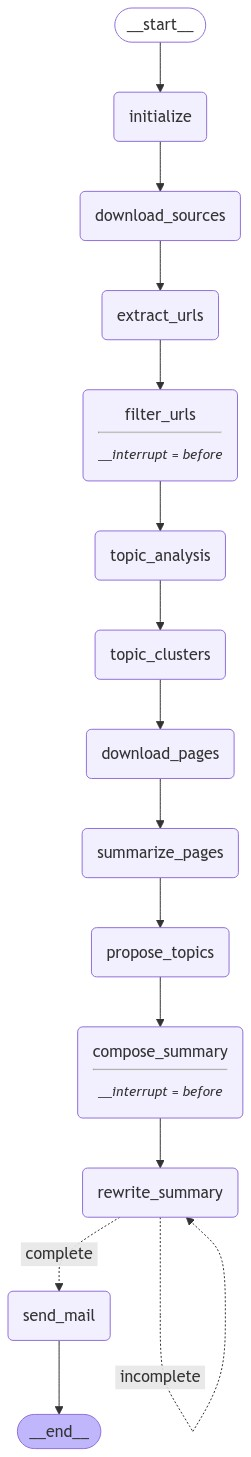

In [33]:
# Image(lg_agent.graph.get_graph().draw_png())
Image(lg_agent.app.get_graph().draw_mermaid_png())


In [ ]:
do_download = True
before_date = None
# before_date="2024-07-22 10:00:00"


In [ ]:
# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}
# initial state
state = AgentState()
state["before_date"] = before_date
state["do_download"] = do_download
log(f"Starting with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")
lg_agent.run(config, state)


In [ ]:
user_approval = input("Edit topics? (yes/no): ")


In [ ]:
if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in lg_agent.graph.stream(None, config, stream_mode="debug"):
        if step["type"] == "checkpoint":
            display(f'Step {step["step"]}')
else:
    print("Operation cancelled by user.")


In [ ]:
# get last state
last_state = lg_agent.graph.get_state(config)
pd.DataFrame(last_state.values['AIdf'])


In [ ]:
# update state as node
# lg_agent.graph.update_state(config, {"foo": 2, "bar": ["b"]}, as_node="revise_summary")


In [ ]:
# resume from error starting at a node
# result = lg_agent.graph.invoke(None, {'configurable': {'thread_id': 'newsbot-thread-5'}, "next": "topic_analysis"})